In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import zscore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import scipy.stats as stats
sns.set_palette('deep')
sns.set(color_codes='True')
from statsmodels.graphics.factorplots import interaction_plot

# Problem 1

In [2]:
#import the dataset
df = pd.read_csv('SalaryData.csv')
df.head()

,Education,Occupation,Salary
0,Doctorate,Adm-clerical,153197
1,Doctorate,Adm-clerical,115945
2,Doctorate,Adm-clerical,175935
3,Doctorate,Adm-clerical,220754
4,Doctorate,Sales,170769


In [3]:
# concise data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Education   40 non-null     object
 1   Occupation  40 non-null     object
 2   Salary      40 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


In [4]:
# unique values of object column - Education
df['Education'].unique()

array([' Doctorate', ' Bachelors', ' HS-grad'], dtype=object)

In [5]:
# unique values of object column - Occupation
df['Occupation'].unique()

array([' Adm-clerical', ' Sales', ' Prof-specialty', ' Exec-managerial'],
      dtype=object)

In [6]:
# Check for null values
print('Number of null values: {}'.format(df.isnull().sum().sum()))

Number of null values: 0


In [7]:
# Check for duplicates
print('Number of duplicate rows: {}'.format(df.duplicated().sum()))

Number of duplicate rows: 0


In [8]:
# Data summary
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Education,40,3,Doctorate,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,40,4,Prof-specialty,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary,40.0,NaN,NaN,NaN,162186.875,64860.407506,50103.0,99897.5,169100.0,214440.75,260151.0


ShapiroResult(statistic=0.9401417970657349, pvalue=0.03496258333325386)


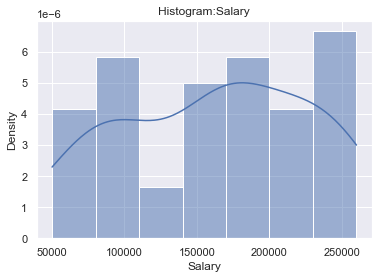

In [9]:
# Check if 'Salary' follows a normal population
print(stats.shapiro(df['Salary']))
sns.histplot(df['Salary'],kde=True,stat='density');
plt.title('Histogram:Salary');

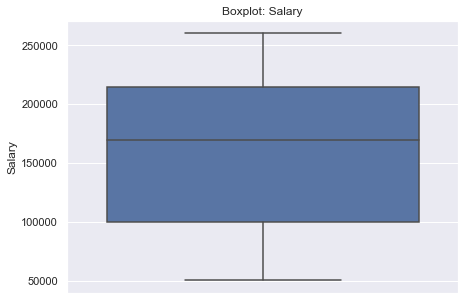

In [10]:
# Check for outliers
plt.figure(figsize=(7,5))
sns.boxplot(y=df['Salary']);
plt.title('Boxplot: Salary');

In [11]:
# Since the columns 'Education' and 'Occupation' are categorical, lets convert them into categorical data type
df['Education'] = pd.Categorical(df['Education'])
df['Occupation'] = pd.Categorical(df['Occupation'])

In [12]:
# Re-check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Education   40 non-null     category
 1   Occupation  40 non-null     category
 2   Salary      40 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 864.0 bytes


## 1.2 Perform a one-way ANOVA on Salary with respect to Education. State whether the null hypothesis is accepted or rejected based on the ANOVA results.

In [13]:
# Lets check if 'Salary' sample is normal for each of the education levels
# We can perform Shapiro-Wilk test for each of the sample with the following hypothesis
# Ho (Null Hypothesis) - Sample follows a normal distribution
# ha (Alternate Hypothesis) - Sample does not follow a normal distribution.

print('Education type- Doctorate : {}'.format(stats.shapiro(df[df['Education'] == ' Doctorate']['Salary'])))
print('Education type- Bachelors : {}'.format(stats.shapiro(df[df['Education'] == ' Bachelors']['Salary'])))
print('Education type- HS-grad   : {}'.format(stats.shapiro(df[df['Education'] == ' HS-grad']['Salary'])))

Education type- Doctorate : ShapiroResult(statistic=0.8952829837799072, pvalue=0.0675690770149231)
Education type- Bachelors : ShapiroResult(statistic=0.9607304334640503, pvalue=0.7050924301147461)
Education type- HS-grad   : ShapiroResult(statistic=0.885286271572113, pvalue=0.1783432960510254)


#### Since the pvalues are greater than 0.05 for the Shapiro-Wilk test performed on the 3 samples, we do not have enough evidence to reject the null hypothesis and hence, all 3 samples follow normal distribution.

In [14]:
# Lets check if 'Salary' sample has equal variance for each of the education levels
# We can perform Levene's test for the samples with the following hypothesis
# Ho (Null Hypothesis) - All samples have the same variance
# ha (Alternate Hypothesis) - Atleast one sample have variance not equal to others.

print(stats.levene(df[df['Education'] == ' Doctorate']['Salary'],df[df['Education'] == ' Bachelors']['Salary'],
                   df[df['Education'] == ' HS-grad']['Salary']))

LeveneResult(statistic=1.8800921605836554, pvalue=0.16686425699301183)


#### Since the pvalue is greater than 0.05 for the Levene's test performed on the 3 samples, we do not have enough evidence to reject the null hypothesis and hence, the 3 samples have the same variance.

In [15]:
# One-way Anova - Salary/Education
# Ho – Null Hypothesis – The means of Salary variable with respect to each Education type is same.
# Ha – Alternate Hypothesis – At least one of the means of Salary variable with respect to each Education type is different.

formula = 'Salary ~ C(Education)'
model   = ols(formula,df).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Education),2.0,1.026955e+11,5.134773e+10,30.95628,1.257709e-08
Residual,37.0,6.137256e+10,1.658718e+09,NaN,NaN


#### Since pvalue is less than 0.05, we have enough evidence to reject the null hypothesis, hence atleast one of the means of Salary variable with respect to Education type is different from others.

## 1.3 Perform one-way ANOVA for variable Occupation with respect to the variable ‘Salary’. State whether the null hypothesis is accepted or rejected based on the ANOVA results.

In [16]:
# Lets check if 'Salary' sample is normal for each of the occupation type
# We can perform Shapiro-Wilk test for each of the sample with the following hypothesis
# Ho (Null Hypothesis) - Sample follows a normal distribution
# ha (Alternate Hypothesis) - Sample does not follow a normal distribution.

print('Occupation type- Adm-clerical    : {}'.format(stats.shapiro(df[df['Occupation'] == ' Adm-clerical']['Salary'])))
print('Occupation type- Sales           : {}'.format(stats.shapiro(df[df['Occupation'] == ' Sales']['Salary'])))
print('Occupation type- Prof-specialty  : {}'.format(stats.shapiro(df[df['Occupation'] == ' Prof-specialty']['Salary'])))
print('Occupation type- Exec-managerial : {}'.format(stats.shapiro(df[df['Occupation'] == ' Exec-managerial']['Salary'])))


Occupation type- Adm-clerical    : ShapiroResult(statistic=0.9189430475234985, pvalue=0.34822404384613037)
Occupation type- Sales           : ShapiroResult(statistic=0.8897126913070679, pvalue=0.11683900654315948)
Occupation type- Prof-specialty  : ShapiroResult(statistic=0.736305832862854, pvalue=0.0013131146552041173)
Occupation type- Exec-managerial : ShapiroResult(statistic=0.6901877522468567, pvalue=0.007539781276136637)


#### Since the pvalues are not greater than 0.05 for the Shapiro-Wilk test performed on 2 of the samples (occupation type - Prof-specialty and Exec-managerial), we have enough evidence to reject the null hypothesis and hence, the last two samples does not follow normal distribution. The question asks us to assume normal distribution, hence we will proceed with ANOVA.

In [17]:
# Lets check if 'Salary' sample has equal variance for each of the occupation type
# We can perform Levene's test for the samples with the following hypothesis
# Ho (Null Hypothesis) - All samples have the same variance
# ha (Alternate Hypothesis) - Atleast one sample have variance not equal to others.

print(stats.levene(df[df['Occupation'] == ' Adm-clerical']['Salary'],df[df['Occupation'] == ' Sales']['Salary'],
                   df[df['Occupation'] == ' Prof-specialty']['Salary'],  df[df['Occupation'] == ' Exec-managerial']['Salary']))

LeveneResult(statistic=2.4378177404396832, pvalue=0.0803790714975064)


#### Since the pvalue is greater than 0.05 for the Levene's test performed on the 4 samples, we do not have enough evidence to reject the null hypothesis and hence, the 4 samples have the same variance.

In [18]:
# One-way Anova - Salary/Occupation
# Ho – Null Hypothesis – The means of Salary variable with respect to each Occupation type is same.
# Ha – Alternate Hypothesis – At least one of the means of Salary variable with respect to each Occupation type is different.

formula = 'Salary ~ C(Occupation)'
model   = ols(formula,df).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),3.0,1.125878e+10,3.752928e+09,0.884144,0.458508
Residual,36.0,1.528092e+11,4.244701e+09,NaN,NaN


#### Since pvalue is greater than 0.05, we do not have enough evidence to reject the null hypothesis, hence the means of Salary variable with respect to each Occupation type is the same.

## 1.4 If the null hypothesis is rejected in either (1.2) or in (1.3), find out which class means are significantly different. Interpret the result.

In [19]:
# From 1.2 and 1.3 we have seen that ANOVA null hypothesis is rejected in 1.2, where we have found that Salary group means
# are not the same across Education types. Lets perform pairwise tukey test to identify the pair of education types which has
# statistically significant difference in the means.

tukey = pairwise_tukeyhsd(endog = df['Salary'],groups = df['Education'], alpha = 0.05)
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff   p-adj     lower        upper    reject
-------------------------------------------------------------------------
 Bachelors  Doctorate   43274.0667 0.0146    7541.1439  79006.9894   True
 Bachelors    HS-grad  -90114.1556  0.001 -132035.1958 -48193.1153   True
 Doctorate    HS-grad -133388.2222  0.001 -174815.0876 -91961.3569   True
-------------------------------------------------------------------------


#### We can see that the p-values(shown as p-adj in the above table) is lesser than 0.05 for all the 3 pairs of education types. Hence the means of Salary for all the 3 education pairs are significantly different from each other.

## 1.5 What is the interaction between the two treatments? Analyze the effects of one variable on the other (Education and Occupation) with the help of an interaction plot.

<Figure size 1440x1080 with 0 Axes>

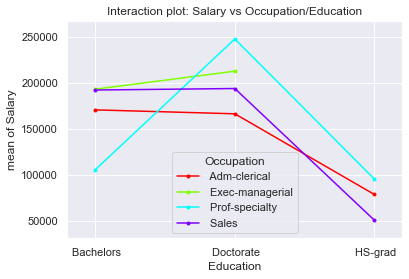

In [20]:
plt.figure(figsize=(20,15));
interaction_plot(df['Education'].astype(str),df['Occupation'].astype(str),df['Salary']);
plt.title('Interaction plot: Salary vs Occupation/Education');

## 1.6	Perform a two-way ANOVA based on the Education and Occupation (along with their interaction Education*Occupation) with the variable ‘Salary’. State the null and alternative hypotheses and state your results. How will you interpret this result?

In [21]:
# Two-way Anova - Salary vs Education/Occupation/interaction
# Ho – Null Hypothesis – The means of Salary variable with respect to each treatment(education type, occupation level, 
#      interaction between education type & occupation level) is the same.
# Ha – Alternate Hypothesis – At least one of the means of Salary variable with respect to each treatment differs from others.

formula = 'Salary ~ C(Education) + C(Occupation) + C(Education)*C(Occupation)'
model   = ols(formula,df).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Education),2.0,1.026955e+11,5.134773e+10,72.211958,5.466264e-12
C(Occupation),3.0,5.519946e+09,1.839982e+09,2.587626,7.211580e-02
C(Education):C(Occupation),6.0,3.634909e+10,6.058182e+09,8.519815,2.232500e-05
Residual,29.0,2.062102e+10,7.110697e+08,NaN,NaN


# Problem 2

### 2.1	Perform Exploratory Data Analysis [both univariate and multivariate analysis to be performed]. What insight do you draw from the EDA?

In [22]:
df = pd.read_csv('Education+-+Post+12th+Standard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Names        777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 

In [23]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Names,777,777,Daniel Webster College,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apps,777.0,NaN,NaN,NaN,3001.638353,3870.201484,81.0,776.0,1558.0,3624.0,48094.0
Accept,777.0,NaN,NaN,NaN,2018.804376,2451.113971,72.0,604.0,1110.0,2424.0,26330.0
Enroll,777.0,NaN,NaN,NaN,779.972973,929.17619,35.0,242.0,434.0,902.0,6392.0
Top10perc,777.0,NaN,NaN,NaN,27.558559,17.640364,1.0,15.0,23.0,35.0,96.0
Top25perc,777.0,NaN,NaN,NaN,55.796654,19.804778,9.0,41.0,54.0,69.0,100.0
F.Undergrad,777.0,NaN,NaN,NaN,3699.907336,4850.420531,139.0,992.0,1707.0,4005.0,31643.0
P.Undergrad,777.0,NaN,NaN,NaN,855.298584,1522.431887,1.0,95.0,353.0,967.0,21836.0
Outstate,777.0,NaN,NaN,NaN,10440.669241,4023.016484,2340.0,7320.0,9990.0,12925.0,21700.0
Room.Board,777.0,NaN,NaN,NaN,4357.526384,1096.696416,1780.0,3597.0,4200.0,5050.0,8124.0


In [24]:
df.head()

,Names,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [25]:
print("Number of null values in dataset is {}".format(df.isnull().sum().sum()))

Number of null values in dataset is 0


In [26]:
print("Number of duplicate observations in dataset is {}".format(df.duplicated().sum()))

Number of duplicate observations in dataset is 0


### Univariate Analysis

ShapiroResult(statistic=0.6540830135345459, pvalue=6.817376668202877e-37)


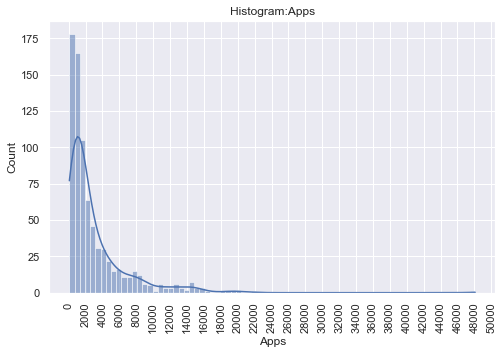

In [27]:
# Univariate analysis - Apps
# Plot Histogram for Apps
plt.figure(figsize=(8,5))
print(stats.shapiro(df['Apps']))
sns.histplot(df['Apps'],kde=True)
plt.title('Histogram:Apps');
plt.xticks(np.arange(0,51000,2000),rotation =90);

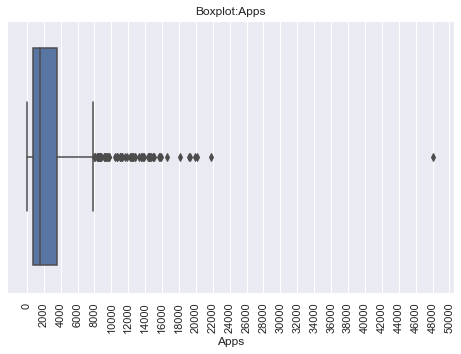

In [28]:
# Plot Boxplot for Apps
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Apps'])
plt.title('Boxplot:Apps');
plt.xticks(np.arange(0,51000,2000),rotation =90);

In [29]:
# Check number of outlier data present in Apps
print ('Number of outliers in Apps column: {}'.format(df[df['Apps'] > 7896]['Apps'].count()))

Number of outliers in Apps column: 70


In [30]:
#Check the top 5 colleges w.r.t number of applications.
df.sort_values('Apps')[['Names','Apps']].head()

,Names,Apps
110,Christendom College,81
85,Capitol College,100
135,College of St. Joseph,141
500,Saint Mary-of-the-Woods College,150
768,Wisconsin Lutheran College,152


In [31]:
#Check the bottom 5 colleges w.r.t number of applications.
df.sort_values('Apps')[['Names','Apps']].tail()

,Names,Apps
445,Pennsylvania State Univ. Main Campus,19315
605,University of California at Berkeley,19873
59,Boston University,20192
461,Purdue University at West Lafayette,21804
483,Rutgers at New Brunswick,48094


ShapiroResult(statistic=0.6642086505889893, pvalue=1.7156291262643952e-36)


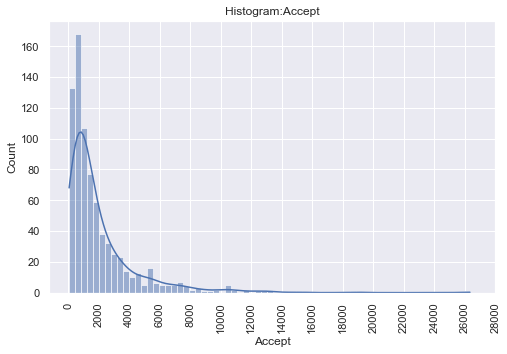

In [32]:
# Univariate analysis - Accept
# Plot the histogram of Accept
print(stats.shapiro(df['Accept']))
plt.figure(figsize=(8,5))
sns.histplot(df['Accept'],kde=True)
plt.title('Histogram:Accept');
plt.xticks(np.arange(0,29000,2000),rotation =90);

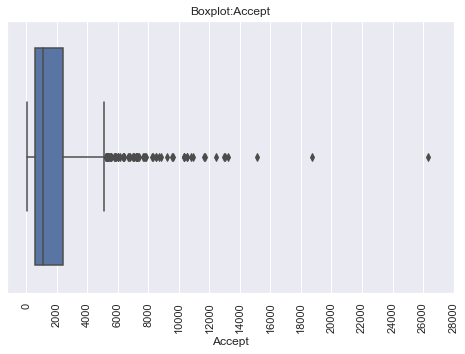

In [33]:
# Plot the boxplot of Accept
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Accept'])
plt.title('Boxplot:Accept');
plt.xticks(np.arange(0,29000,2000),rotation =90);

In [34]:
# Check the number of outliers in Accept
print ('Number of outliers in Accept column: {}'.format(df[df['Accept'] > 5154]['Accept'].count()))

Number of outliers in Accept column: 73


In [35]:
#Check the top 5 colleges w.r.t number of Applications accepted.
df.sort_values('Accept')[['Names','Accept']].head()

,Names,Accept
110,Christendom College,72
85,Capitol College,90
135,College of St. Joseph,118
768,Wisconsin Lutheran College,128
764,Wilson College,130


In [36]:
#Check the bottom 5 colleges w.r.t number of Applications accepted.
df.sort_values('Accept')[['Names','Accept']].tail()

,Names,Accept
59,Boston University,13007
274,Indiana University at Bloomington,13243
366,Michigan State University,15096
461,Purdue University at West Lafayette,18744
483,Rutgers at New Brunswick,26330


ShapiroResult(statistic=0.6783359050750732, pvalue=6.460356670479904e-36)


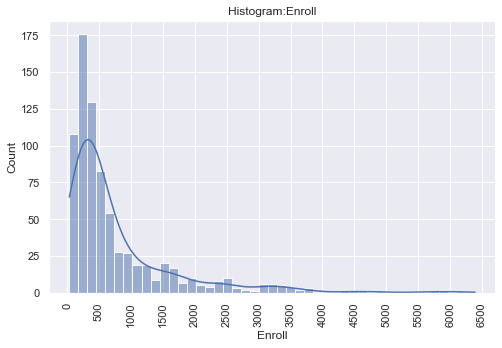

In [37]:
# Univariate analysis - Enroll
# Plot the histogram of Enroll
print(stats.shapiro(df['Enroll']))
plt.figure(figsize=(8,5))
sns.histplot(df['Enroll'],kde=True)
plt.title('Histogram:Enroll');
plt.xticks(np.arange(0,7000,500),rotation =90);

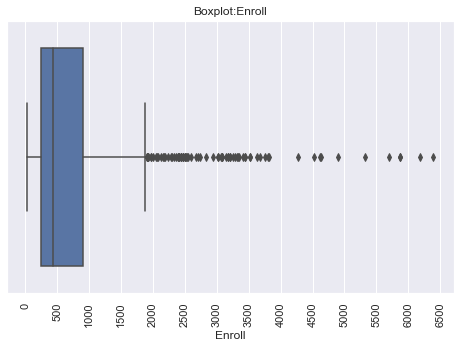

In [38]:
# Plot the boxplot of Enroll
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Enroll'])
plt.title('Boxplot:Enroll');
plt.xticks(np.arange(0,7000,500),rotation =90);

In [39]:
# Check for the number of outliers in Enroll
print ('Number of outliers in Enroll column: {}'.format(df[df['Enroll'] > 5154]['Enroll'].count()))

Number of outliers in Enroll column: 6


In [40]:
#Check the bottom 5 colleges w.r.t number of Enrollments. 
df.sort_values('Enroll')[['Names','Enroll']].head()

,Names,Enroll
85,Capitol College,35
764,Wilson College,46
110,Christendom College,51
135,College of St. Joseph,55
4,Alaska Pacific University,55


In [41]:
#Check the top 5 colleges w.r.t number of Enrollments.
df.sort_values('Enroll')[['Names','Enroll']].tail()

,Names,Enroll
623,University of Illinois - Urbana,5705
274,Indiana University at Bloomington,5873
461,Purdue University at West Lafayette,5874
366,Michigan State University,6180
581,Texas A&M Univ. at College Station,6392


ShapiroResult(statistic=0.8874172568321228, pvalue=2.4506751303874142e-23)


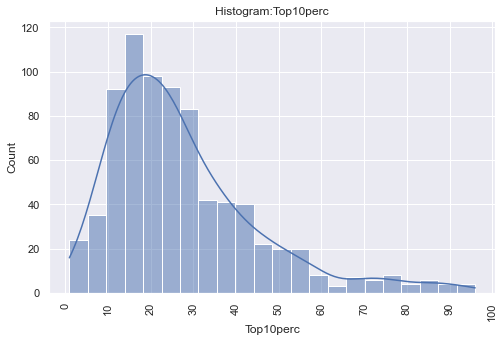

In [42]:
# Univariate analysis - Top10perc
# Plot histogram of Top10perc
print(stats.shapiro(df['Top10perc']))
plt.figure(figsize=(8,5))
sns.histplot(df['Top10perc'],kde=True)
plt.title('Histogram:Top10perc');
plt.xticks(np.arange(0,110,10),rotation =90);

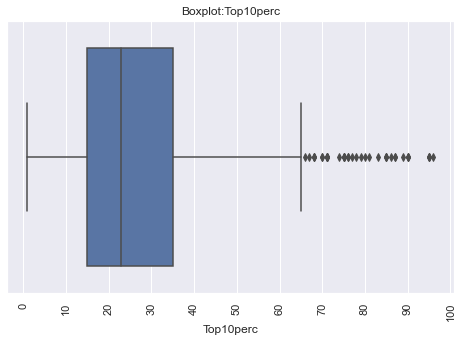

In [43]:
# Plot boxplot of Top10perc
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Top10perc'])
plt.title('Boxplot:Top10perc');
plt.xticks(np.arange(0,110,10),rotation =90);

In [44]:
# Check for number of outliers in Top10perc
print ('Number of outliers in Top10perc column: {}'.format(df[df['Top10perc'] > 65]['Top10perc'].count()))

Number of outliers in Top10perc column: 39


In [45]:
#Check the bottom 5 colleges w.r.t percent value of Top10perc. 
df.sort_values('Top10perc')[['Names','Top10perc']].head()

,Names,Top10perc
197,Fayetteville State University,1
100,Center for Creative Studies,1
410,North Adams State College,1
389,Morris College,2
712,Virginia State University,2


In [46]:
#Check the top 5 colleges w.r.t percent value of Top10perc. 
df.sort_values('Top10perc')[['Names','Top10perc']].tail()

,Names,Top10perc
174,Duke University,90
605,University of California at Berkeley,95
251,Harvey Mudd College,95
775,Yale University,95
354,Massachusetts Institute of Technology,96


ShapiroResult(statistic=0.9839921593666077, pvalue=1.6668367663896788e-07)


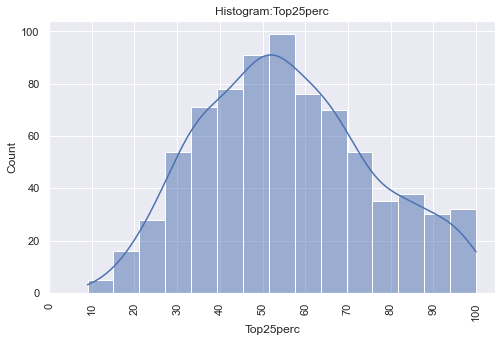

In [47]:
# Univariate analysis - Top25perc
#Plot the histogram of Top25perc
print(stats.shapiro(df['Top25perc']))
plt.figure(figsize=(8,5))
sns.histplot(df['Top25perc'],kde=True)
plt.title('Histogram:Top25perc');
plt.xticks(np.arange(0,110,10),rotation =90);

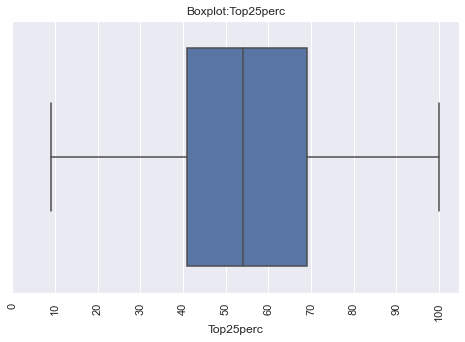

In [48]:
# Plot the boxplot of Top25perc
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Top25perc'])
plt.title('Boxplot:Top25perc');
plt.xticks(np.arange(0,110,10),rotation =90);

In [49]:
# Check for number of outliers in Top10perc
print ('Number of outliers in Top25perc column: {}'.format(df[df['Top25perc'] > 100]['Top25perc'].count()))

Number of outliers in Top25perc column: 0


In [50]:
#Check the bottom 5 colleges w.r.t percent value of Top25perc. 
df.sort_values('Top25perc')[['Names','Top25perc']].head()

,Names,Top25perc
264,Huron University,9
355,Mayville State University,12
285,Johnson State College,13
389,Morris College,13
210,Franklin Pierce College,14


In [51]:
#Check the top 5 colleges w.r.t percent value of Top25perc. 
df.sort_values('Top25perc')[['Names','Top25perc']].tail()

,Names,Top25perc
250,Harvard University,100
606,University of California at Irvine,100
562,SUNY at Buffalo,100
605,University of California at Berkeley,100
663,University of Pennsylvania,100


In [52]:
# Since we have max percent value as 100, lets check all colleges having 100%
df[df['Top25perc'] == 100][['Names','Top25perc']]

,Names,Top25perc
60,Bowdoin College,100
250,Harvard University,100
251,Harvey Mudd College,100
562,SUNY at Buffalo,100
605,University of California at Berkeley,100
606,University of California at Irvine,100
663,University of Pennsylvania,100


ShapiroResult(statistic=0.6561151742935181, pvalue=8.190183707943287e-37)


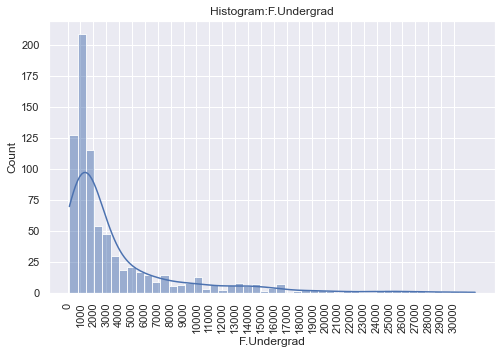

In [53]:
# Univariate analysis - F.Undergrad
# Plot the histogram for F.Undergrad
print(stats.shapiro(df['F.Undergrad']))
plt.figure(figsize=(8,5))
sns.histplot(df['F.Undergrad'],kde=True)
plt.title('Histogram:F.Undergrad');
plt.xticks(np.arange(0,31000,1000),rotation =90);

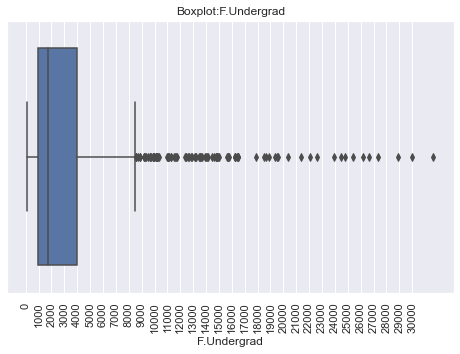

In [54]:
# Plot the boxplot for F.Undergrad
plt.figure(figsize=(8,5))
sns.boxplot(x=df['F.Undergrad'])
plt.title('Boxplot:F.Undergrad');
plt.xticks(np.arange(0,31000,1000),rotation =90);

In [55]:
# Check the number of outliers in F.Undergrad
print ('Number of outliers in F.Undergrad column: {}'.format(df[df['F.Undergrad'] > 8524.5]['F.Undergrad'].count()))

Number of outliers in F.Undergrad column: 97


In [56]:
#Check the bottom 5 colleges w.r.t value of F.Undergrad. 
df.sort_values('F.Undergrad')[['Names','F.Undergrad']].head()

,Names,F.Undergrad
110,Christendom College,139
764,Wilson College,199
135,College of St. Joseph,201
4,Alaska Pacific University,249
768,Wisconsin Lutheran College,282


In [57]:
#Check the top 5 colleges w.r.t value of F.Undergrad. 
df.sort_values('F.Undergrad')[['Names','F.Undergrad']].tail()

,Names,F.Undergrad
366,Michigan State University,26640
69,Brigham Young University at Provo,27378
445,Pennsylvania State Univ. Main Campus,28938
685,University of Texas at Austin,30017
581,Texas A&M Univ. at College Station,31643


ShapiroResult(statistic=0.5230939388275146, pvalue=2.2660397466596617e-41)


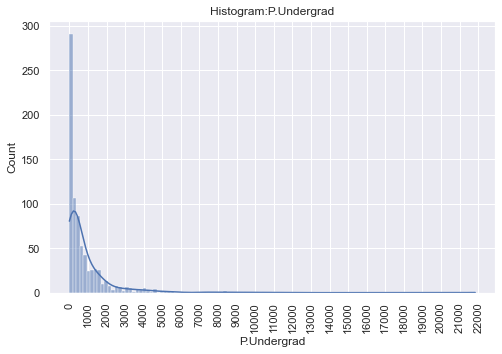

In [58]:
# Univariate analysis - P.Undergrad
# Plot the histogram of P.Undergrad
print(stats.shapiro(df['P.Undergrad']))
plt.figure(figsize=(8,5))
sns.histplot(df['P.Undergrad'],kde=True)
plt.title('Histogram:P.Undergrad');
plt.xticks(np.arange(0,23000,1000),rotation =90);

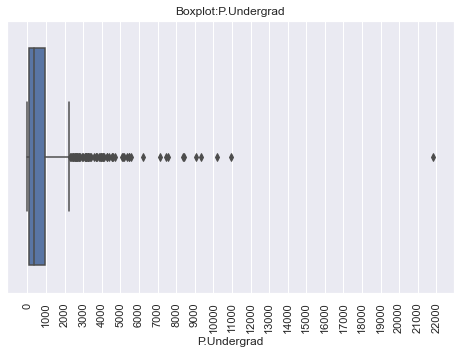

In [59]:
# Plot the boxplot of P.Undergrad
plt.figure(figsize=(8,5))
sns.boxplot(x=df['P.Undergrad'])
plt.title('Boxplot:P.Undergrad');
plt.xticks(np.arange(0,23000,1000),rotation =90);

In [60]:
# Check the number of outliers in P.Undergrad
print ('Number of outliers in P.Undergrad column: {}'.format(df[df['P.Undergrad'] > 2275]['P.Undergrad'].count()))

Number of outliers in P.Undergrad column: 67


In [61]:
#Check the bottom 5 colleges w.r.t value of P.Undergrad. 
df.sort_values('P.Undergrad')[['Names','P.Undergrad']].head()

,Names,P.Undergrad
114,Claremont McKenna College,1
139,College of Wooster,1
244,Hampden - Sydney College,1
292,Kenyon College,1
47,Bennington College,2


In [62]:
#Check the top 5 colleges w.r.t value of P.Undergrad. 
df.sort_values('P.Undergrad')[['Names','P.Undergrad']].tail()

,Names,P.Undergrad
223,Georgia State University,9054
201,Florida International University,9310
418,Northeastern University,10221
676,University of South Florida,10962
640,University of Minnesota Twin Cities,21836


ShapiroResult(statistic=0.9675878286361694, pvalue=4.178048965824965e-12)


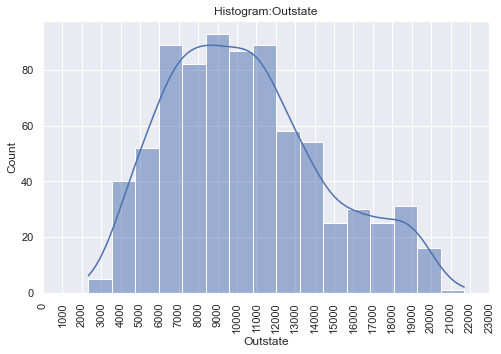

In [63]:
# Univariate analysis - Outstate
# Plot the histogram for Outstate
print(stats.shapiro(df['Outstate']))
plt.figure(figsize=(8,5))
sns.histplot(df['Outstate'],kde=True)
plt.title('Histogram:Outstate');
plt.xticks(np.arange(0,24000,1000),rotation =90);

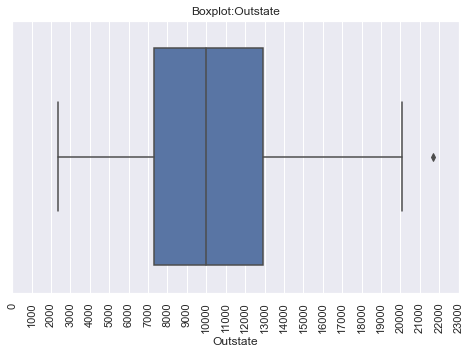

In [64]:
# Plot the boxplot for Outstate
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Outstate'])
plt.title('Boxplot:Outstate');
plt.xticks(np.arange(0,24000,1000),rotation =90);

In [65]:
# Check the number of outliers for Outstate
print ('Number of outliers in Outstate column: {}'.format(df[df['Outstate'] > 21332.5]['Outstate'].count()))

Number of outliers in Outstate column: 1


In [66]:
#Check the bottom 5 colleges w.r.t value of Outstate. 
df.sort_values('Outstate')[['Names','Outstate']].head()

,Names,Outstate
69,Brigham Young University at Provo,2340
447,Peru State College,2580
729,Wayne State College,2700
558,Stockton College of New Jersey,3040
25,Arkansas Tech University,3460


In [67]:
#Check the top 5 colleges w.r.t value of Outstate. 
df.sort_values('Outstate')[['Names','Outstate']].tail()

,Names,Outstate
459,Princeton University,19900
469,Reed College,19960
225,Gettysburg College,19964
354,Massachusetts Institute of Technology,20100
47,Bennington College,21700


ShapiroResult(statistic=0.9797195196151733, pvalue=6.606378555318315e-09)


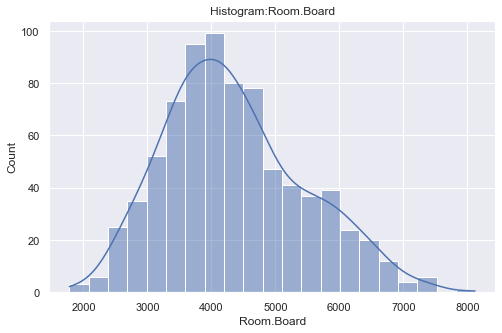

In [68]:
# Univariate analysis - Room.Board
# Plot the histogram for Room.Board
print(stats.shapiro(df['Room.Board']))
plt.figure(figsize=(8,5))
sns.histplot(df['Room.Board'],kde=True)
plt.title('Histogram:Room.Board');

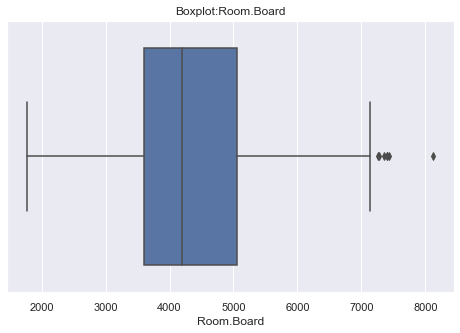

In [69]:
# Plot the boxplot for Room.Board
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Room.Board'])
plt.title('Boxplot:Room.Board');

In [70]:
# Check the number of outliers in Room.Board
print ('Number of outliers in Room.Board column: {}'.format(df[df['Room.Board'] > 7229.5]['Room.Board'].count()))

Number of outliers in Room.Board column: 7


In [71]:
#Check the bottom 5 colleges w.r.t value of Room.Board. 
df.sort_values('Room.Board')[['Names','Room.Board']].head()

,Names,Room.Board
411,North Carolina A. & T. State University,1780
161,Delta State University,1880
672,University of Sci. and Arts of Oklahoma,1920
165,Dickinson State University,2146
529,South Dakota State University,2190


In [72]:
#Check the bottom 5 colleges w.r.t value of Room.Board. 
df.sort_values('Room.Board')[['Names','Room.Board']].tail()

,Names,Room.Board
515,Scripps College,7350
414,North Central College,7398
346,Mary Baldwin College,7400
418,Northeastern University,7425
37,Barnard College,8124


ShapiroResult(statistic=0.7714343667030334, pvalue=1.6500736287944575e-31)


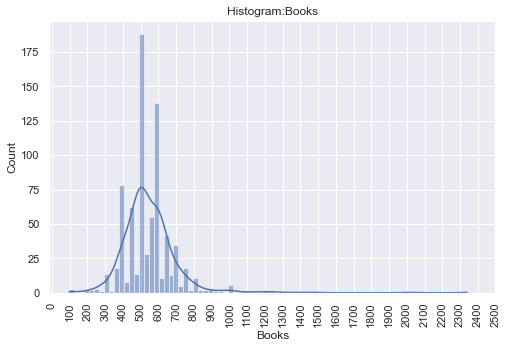

In [73]:
# Univariate analysis - Books
#Plot the histogram of Books
print(stats.shapiro(df['Books']))
plt.figure(figsize=(8,5))
sns.histplot(df['Books'],kde=True)
plt.title('Histogram:Books');
plt.xticks(np.arange(0,2600,100),rotation =90);

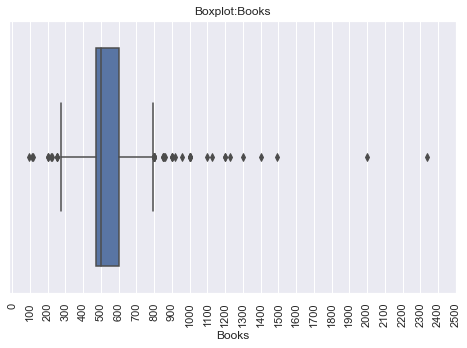

In [74]:
#Plot the boxplot of Books
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Books'])
plt.title('Boxplot:Books');
plt.xticks(np.arange(0,2600,100),rotation =90);

In [75]:
# Check the number of outliers in Books column
print ('Number of outliers in Books column: {}'.format(df[(df['Books'] > 795) | (df['Books'] < 275)]['Books'].count()))

Number of outliers in Books column: 46


In [76]:
#Check the bottom 5 colleges w.r.t value of Books. 
df.sort_values('Books')[['Names','Books']].head()

,Names,Books
21,Appalachian State University,96
741,Western Carolina University,110
181,Eastern Illinois University,120
530,Southeast Missouri State University,200
377,Missouri Southern State College,200


In [77]:
#Check the top 5 colleges w.r.t value of Books. 
df.sort_values('Books')[['Names','Books']].tail()

,Names,Books
687,University of the Arts,1300
737,Wesleyan University,1400
60,Bowdoin College,1495
63,Bradley University,2000
100,Center for Creative Studies,2340


ShapiroResult(statistic=0.8930280804634094, pvalue=8.492892282827518e-23)


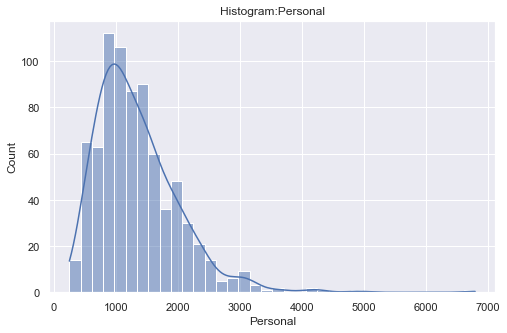

In [78]:
# Univariate analysis - Personal
# Plot the histogram of Personal
print(stats.shapiro(df['Personal']))
plt.figure(figsize=(8,5))
sns.histplot(df['Personal'],kde=True)
plt.title('Histogram:Personal');
#plt.xticks(np.arange(0,2600,100),rotation =90);

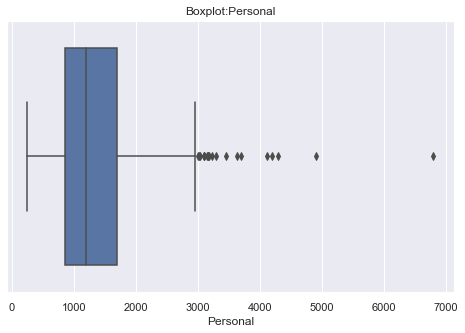

In [79]:
# Plot the boxplot of Personal
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Personal'])
plt.title('Boxplot:Personal');
#plt.xticks(np.arange(0,2600,100),rotation =90);

In [80]:
# Check the numberof outliers in Personal.
print ('Number of outliers in Personal column: {}'.format(df[df['Personal'] > 2975]['Personal'].count()))

Number of outliers in Personal column: 20


In [81]:
#Check the bottom 5 colleges w.r.t value of Personal. 
df.sort_values('Personal')[['Names','Personal']].head()

,Names,Personal
46,Benedictine College,250
726,Washington College,300
710,Villanova University,300
75,Cabrini College,300
144,Columbia University,300


In [82]:
#Check the top 5 colleges w.r.t value of Personal. 
df.sort_values('Personal')[['Names','Personal']].tail()

,Names,Personal
430,Oglethorpe University,4110
317,Lindenwood College,4200
644,University of Missouri at Saint Louis,4288
368,MidAmerica Nazarene College,4913
497,Saint Louis University,6800


In [83]:
# Univariate analysis - PhD
# We have an erroneous percentage value in column PhD
df[df['PhD'] > 100]

,Names,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
582,Texas A&M University at Galveston,529,481,243,22,47,1206,134,4860,3122,600,650,103,88,17.4,16,6415,43


In [84]:
#We will impute the erroneous observation for PhD with the median value.
df.PhD.replace(103,df['PhD'].median(),inplace=True)
df.iloc[582,:]

Names          Texas A&M University at Galveston
Apps                                         529
Accept                                       481
Enroll                                       243
Top10perc                                     22
Top25perc                                     47
F.Undergrad                                 1206
P.Undergrad                                  134
Outstate                                    4860
Room.Board                                  3122
Books                                        600
Personal                                     650
PhD                                           75
Terminal                                      88
S.F.Ratio                                   17.4
perc.alumni                                   16
Expend                                      6415
Grad.Rate                                     43
Name: 582, dtype: object

In [85]:
# Lets check the data summary post data imputation for PhD column.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Apps,777.0,3001.638353,3870.201484,81.0,776.0,1558.0,3624.0,48094.0
Accept,777.0,2018.804376,2451.113971,72.0,604.0,1110.0,2424.0,26330.0
Enroll,777.0,779.972973,929.176190,35.0,242.0,434.0,902.0,6392.0
Top10perc,777.0,27.558559,17.640364,1.0,15.0,23.0,35.0,96.0
Top25perc,777.0,55.796654,19.804778,9.0,41.0,54.0,69.0,100.0
F.Undergrad,777.0,3699.907336,4850.420531,139.0,992.0,1707.0,4005.0,31643.0
P.Undergrad,777.0,855.298584,1522.431887,1.0,95.0,353.0,967.0,21836.0
Outstate,777.0,10440.669241,4023.016484,2340.0,7320.0,9990.0,12925.0,21700.0
Room.Board,777.0,4357.526384,1096.696416,1780.0,3597.0,4200.0,5050.0,8124.0
Books,777.0,549.380952,165.105360,96.0,470.0,500.0,600.0,2340.0


ShapiroResult(statistic=0.9582453370094299, pvalue=4.5626720582064503e-14)


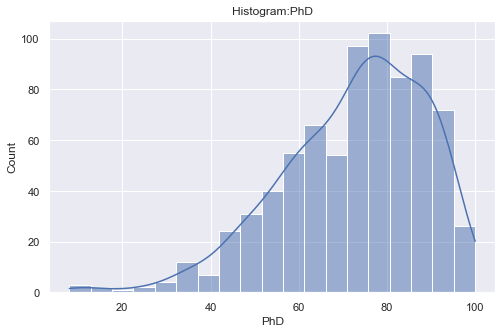

In [86]:
# Plot the histogram of PhD
print(stats.shapiro(df['PhD']))
plt.figure(figsize=(8,5))
sns.histplot(df['PhD'],kde=True)
plt.title('Histogram:PhD');

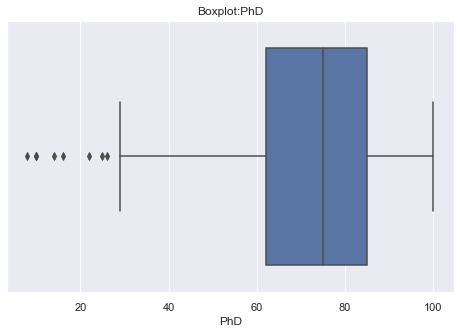

In [87]:
#Boxplot of column 'PhD'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['PhD'])
plt.title('Boxplot:PhD');

In [88]:
# Check the number of outliers in PhD
print ('Number of outliers in PhD column: {}'.format(df[df['PhD'] < 27.5]['PhD'].count()))

Number of outliers in PhD column: 8


In [89]:
#Check the bottom 5 colleges w.r.t value of PhD. 
df.sort_values('PhD')[['Names','PhD']].head()

,Names,PhD
100,Center for Creative Studies,8
735,Wentworth Institute of Technology,10
85,Capitol College,10
513,Savannah Coll. of Art and Design,14
687,University of the Arts,16


In [90]:
#Check the top 5 colleges w.r.t value of PhD. 
df.sort_values('PhD')[['Names','PhD']].tail()

,Names,PhD
256,Hobart and William Smith Colleges,99
114,Claremont McKenna College,99
251,Harvey Mudd College,100
453,Pitzer College,100
71,Bryn Mawr College,100


ShapiroResult(statistic=0.9382799863815308, pvalue=2.0385700760246856e-17)


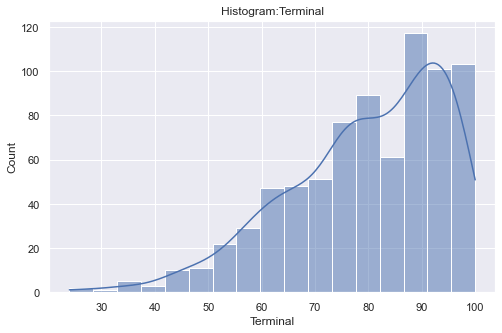

In [91]:
# Univariate analysis - Terminal
# Plot the histogram of Terminal
print(stats.shapiro(df['Terminal']))
plt.figure(figsize=(8,5))
sns.histplot(df['Terminal'],kde=True)
plt.title('Histogram:Terminal');
#plt.xticks(np.arange(0,2600,100),rotation =90);

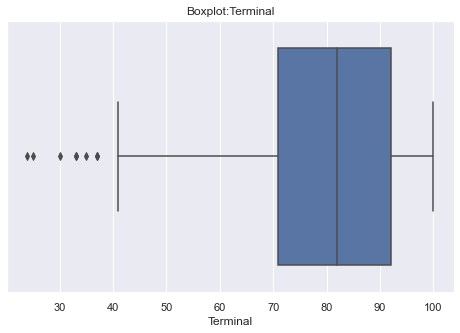

In [92]:
#Boxplot of column 'Terminal'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Terminal'])
plt.title('Boxplot:Terminal');

In [93]:
# Check the number of outliers in Terminal
print ('Number of outliers in Terminal column: {}'.format(df[df['Terminal'] < 39.5]['Terminal'].count()))

Number of outliers in Terminal column: 8


In [94]:
#Check the bottom 5 colleges w.r.t value of Terminal. 
df.sort_values('Terminal')[['Names','Terminal']].head()

,Names,Terminal
506,Salem-Teikyo University,24
226,Goldey Beacom College,25
1,Adelphi University,30
739,West Liberty State College,33
368,MidAmerica Nazarene College,33


In [95]:
#Check the top 5 colleges w.r.t value of Terminal. 
df.sort_values('Terminal')[['Names','Terminal']].tail()

,Names,Terminal
447,Peru State College,100
424,Northwestern University,100
406,New Mexico Institute of Mining and Tech.,100
251,Harvey Mudd College,100
71,Bryn Mawr College,100


In [96]:
# Since there are colleges with professors having 100% terminal degree, lets get their list
df[df['Terminal'] == 100][['Names','Terminal']]

,Names,Terminal
7,Albion College,100
70,Brown University,100
71,Bryn Mawr College,100
251,Harvey Mudd College,100
406,New Mexico Institute of Mining and Tech.,100
409,Niagara University,100
424,Northwestern University,100
447,Peru State College,100
453,Pitzer College,100
505,Saint Xavier University,100


ShapiroResult(statistic=0.9718925356864929, pvalue=4.4927048192811014e-11)


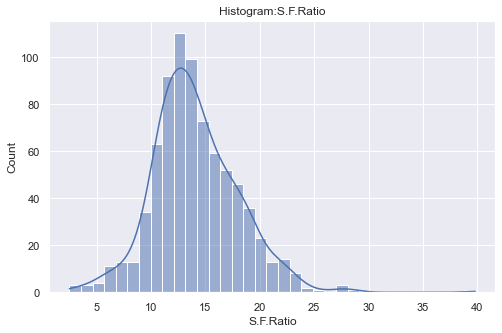

In [97]:
# Univariate analysis - S.F.Ratio
# Plot the histogram of S.F.Ratio
print(stats.shapiro(df['S.F.Ratio']))
plt.figure(figsize=(8,5))
sns.histplot(df['S.F.Ratio'],kde=True)
plt.title('Histogram:S.F.Ratio');
#plt.xticks(np.arange(0,2600,100),rotation =90);

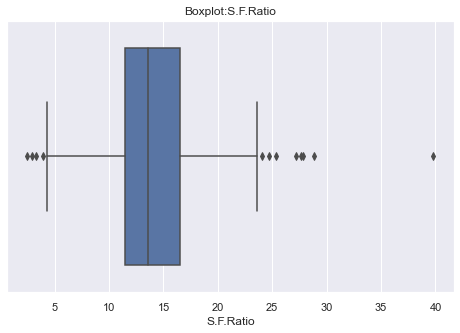

In [98]:
#Boxplot of column 'S.F.Ratio'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['S.F.Ratio'])
plt.title('Boxplot:S.F.Ratio');

In [99]:
# Check the number of outliers in S.F.Ratio
print ('Number of outliers in S.F.Ratio column: {}'.format(df[(df['S.F.Ratio'] < 4) | 
                                                              (df['S.F.Ratio'] > 24)]['S.F.Ratio'].count()))

Number of outliers in S.F.Ratio column: 12


In [100]:
#Check the top 5 colleges w.r.t value of S.F.Ratio. 
df.sort_values('S.F.Ratio')[['Names','S.F.Ratio']].head()

,Names,S.F.Ratio
608,University of Charleston,2.5
91,Case Western Reserve University,2.9
284,Johns Hopkins University,3.3
728,Washington University,3.9
720,Wake Forest University,4.3


In [101]:
#Check the bottom 5 colleges w.r.t value of S.F.Ratio. 
df.sort_values('S.F.Ratio')[['Names','S.F.Ratio']].tail()

,Names,S.F.Ratio
494,Saint Joseph's College,27.2
226,Goldey Beacom College,27.6
311,Lesley College,27.8
363,Mesa State College,28.8
275,Indiana Wesleyan University,39.8


ShapiroResult(statistic=0.9660217761993408, pvalue=1.853275779367669e-12)


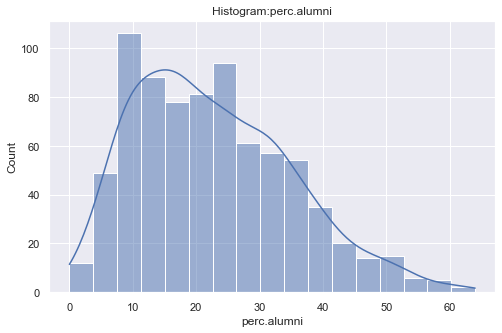

In [102]:
# Univariate analysis - perc.alumni
# Plot the histogram for perc.alumni
print(stats.shapiro(df['perc.alumni']))
plt.figure(figsize=(8,5))
sns.histplot(df['perc.alumni'],kde=True)
plt.title('Histogram:perc.alumni');
#plt.xticks(np.arange(0,2600,100),rotation =90);

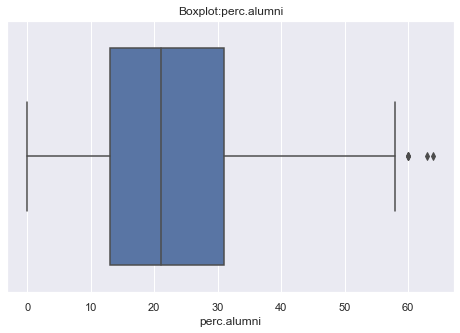

In [103]:
#Boxplot of column 'perc.alumni'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['perc.alumni'])
plt.title('Boxplot:perc.alumni');

In [104]:
# Check the number of outliers in perc.alumni
print ('Number of outliers in perc.alumni column: {}'.format(df[df['perc.alumni'] > 58]['perc.alumni'].count()))

Number of outliers in perc.alumni column: 5


In [105]:
#Check the bottom 5 colleges w.r.t value of perc.alumni. 
df.sort_values('perc.alumni')[['Names','perc.alumni']].head()

,Names,perc.alumni
104,Central Washington University,0
678,University of Southern Colorado,0
457,Prairie View A. and M. University,1
699,University of Wisconsin at Green Bay,1
4,Alaska Pacific University,2


In [106]:
#Check the top 5 colleges w.r.t value of perc.alumni. 
df.sort_values('perc.alumni')[['Names','perc.alumni']].tail()

,Names,perc.alumni
106,Centre College,60
242,Hamilton College,60
86,Carleton College,60
16,Amherst College,63
763,Williams College,64


ShapiroResult(statistic=0.710814356803894, pvalue=1.6428810066138064e-34)


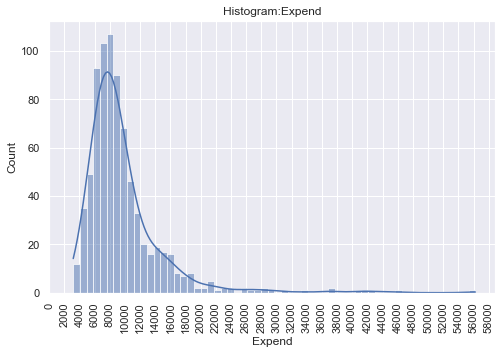

In [107]:
# Univariate analysis - Expend
# Plot the histogram of Expend
print(stats.shapiro(df['Expend']))
plt.figure(figsize=(8,5))
sns.histplot(df['Expend'],kde=True)
plt.title('Histogram:Expend');
plt.xticks(np.arange(0,60000,2000),rotation =90);

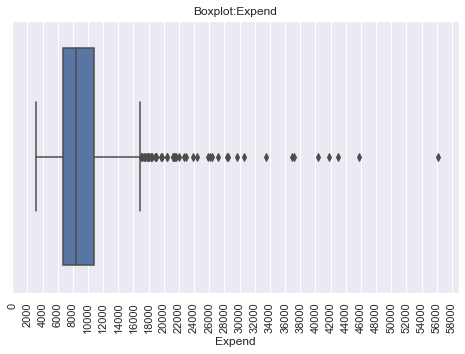

In [108]:
#Boxplot of column 'Expend'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Expend'])
plt.title('Boxplot:Expend');
plt.xticks(np.arange(0,60000,2000),rotation =90);

In [109]:
# Check the number of outliers in Expend
print ('Number of outliers in Expend column: {}'.format(df[df['Expend'] > 16948.5]['Expend'].count()))

Number of outliers in Expend column: 48


In [110]:
#Check the bottom 5 colleges w.r.t value of Expend. 
df.sort_values('Expend')[['Names','Expend']].head()

,Names,Expend
280,Jamestown College,3186
105,Central Wesleyan College,3365
317,Lindenwood College,3480
585,Texas Southern University,3605
703,Upper Iowa University,3733


In [111]:
#Check the top 5 colleges w.r.t value of Expend. 
df.sort_values('Expend')[['Names','Expend']].tail()

,Names,Expend
775,Yale University,40386
720,Wake Forest University,41766
20,Antioch University,42926
728,Washington University,45702
284,Johns Hopkins University,56233


In [112]:
# Univariate analysis - Grad.Rate
# Grad.Rate has an erroneous percentage value 118.
df[df['Grad.Rate'] > 100][['Names','Grad.Rate']]

,Names,Grad.Rate
95,Cazenovia College,118


In [113]:
#We will impute the erroneous observation for Grad.Rate with the median value.
df['Grad.Rate'] = np.where(df['Grad.Rate'] == 118,df['Grad.Rate'].median(),df['Grad.Rate'])
df.iloc[95,:]

Names          Cazenovia College
Apps                        3847
Accept                      3433
Enroll                       527
Top10perc                      9
Top25perc                     35
F.Undergrad                 1010
P.Undergrad                   12
Outstate                    9384
Room.Board                  4840
Books                        600
Personal                     500
PhD                           22
Terminal                      47
S.F.Ratio                   14.3
perc.alumni                   20
Expend                      7697
Grad.Rate                   65.0
Name: 95, dtype: object

In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Apps,777.0,3001.638353,3870.201484,81.0,776.0,1558.0,3624.0,48094.0
Accept,777.0,2018.804376,2451.113971,72.0,604.0,1110.0,2424.0,26330.0
Enroll,777.0,779.972973,929.176190,35.0,242.0,434.0,902.0,6392.0
Top10perc,777.0,27.558559,17.640364,1.0,15.0,23.0,35.0,96.0
Top25perc,777.0,55.796654,19.804778,9.0,41.0,54.0,69.0,100.0
F.Undergrad,777.0,3699.907336,4850.420531,139.0,992.0,1707.0,4005.0,31643.0
P.Undergrad,777.0,855.298584,1522.431887,1.0,95.0,353.0,967.0,21836.0
Outstate,777.0,10440.669241,4023.016484,2340.0,7320.0,9990.0,12925.0,21700.0
Room.Board,777.0,4357.526384,1096.696416,1780.0,3597.0,4200.0,5050.0,8124.0
Books,777.0,549.380952,165.105360,96.0,470.0,500.0,600.0,2340.0


ShapiroResult(statistic=0.9926155209541321, pvalue=0.0006693904288113117)


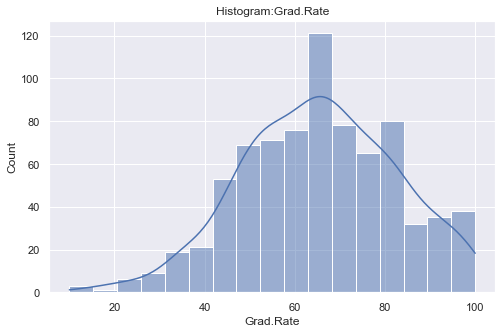

In [115]:
#Plot the histogram of Grad.Rate
print(stats.shapiro(df['Grad.Rate']))
plt.figure(figsize=(8,5))
sns.histplot(df['Grad.Rate'],kde=True)
plt.title('Histogram:Grad.Rate');

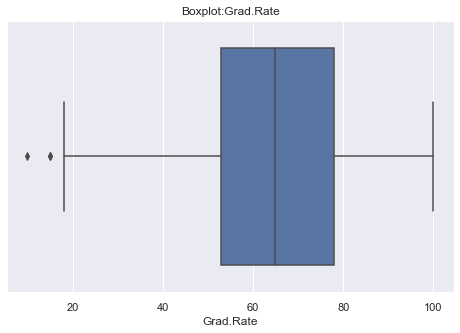

In [116]:
#Boxplot of column 'Grad.Rate'
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Grad.Rate'])
plt.title('Boxplot:Grad.Rate');

In [117]:
# Check for the number of outliers in Grad.Rate
print ('Number of outliers in Grad.Rate column: {}'.format(df[df['Grad.Rate'] < 15.5]['Grad.Rate'].count()))

Number of outliers in Grad.Rate column: 3


In [118]:
#Check the bottom 5 colleges w.r.t value of Grad.Rate. 
df.sort_values('Grad.Rate')[['Names','Grad.Rate']].head()

,Names,Grad.Rate
585,Texas Southern University,10.0
384,Montreat-Anderson College,15.0
4,Alaska Pacific University,15.0
66,Brewton-Parker College,18.0
394,Mount Saint Clare College,21.0


In [119]:
#Check the top 5 colleges w.r.t value of Grad.rate. 
df.sort_values('Grad.Rate')[['Names','Grad.Rate']].tail()

,Names,Grad.Rate
238,Grove City College,100.0
250,Harvard University,100.0
251,Harvey Mudd College,100.0
317,Lindenwood College,100.0
511,Santa Clara University,100.0


In [120]:
# Since we have colleges with a graduate rate of 100%, lets check all such colleges
df[df['Grad.Rate'] == 100][['Names','Grad.Rate']]

,Names,Grad.Rate
16,Amherst College,100.0
126,College of Mount St. Joseph,100.0
238,Grove City College,100.0
250,Harvard University,100.0
251,Harvey Mudd College,100.0
317,Lindenwood College,100.0
377,Missouri Southern State College,100.0
511,Santa Clara University,100.0
522,Siena College,100.0
668,University of Richmond,100.0


### Multivariate Analysis

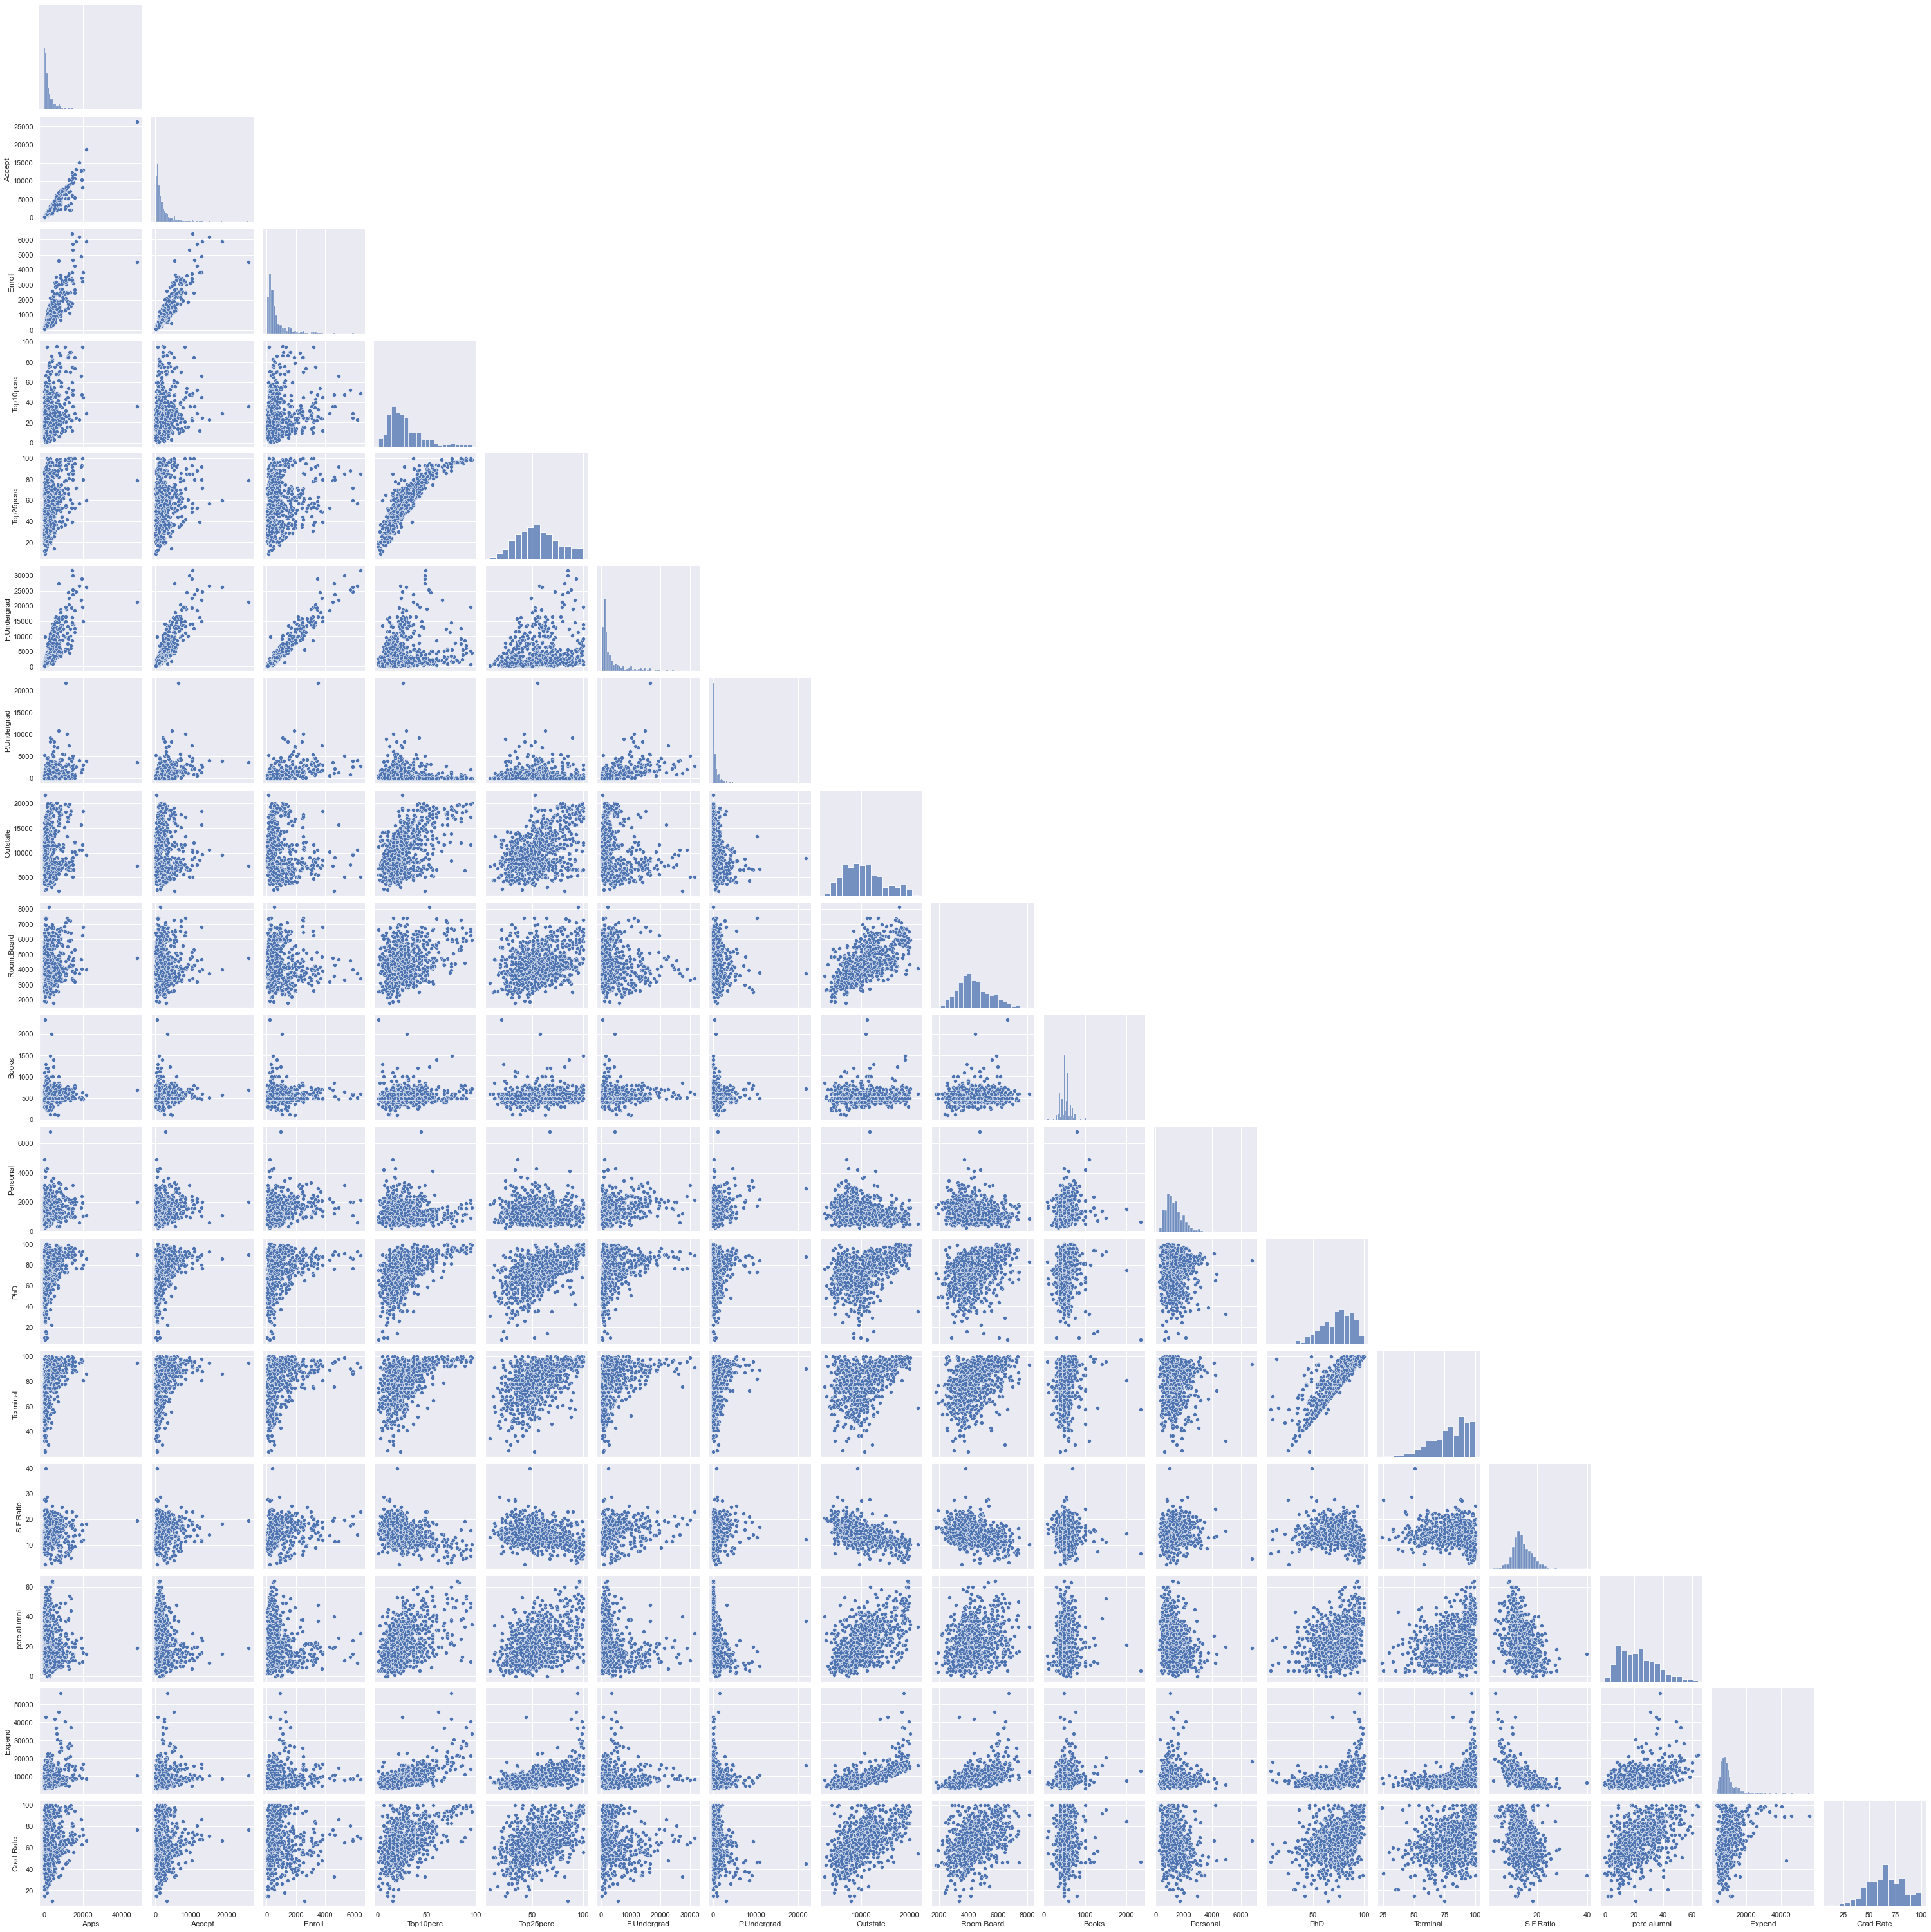

In [121]:
# Lets plot a pair plot
sns.pairplot(data=df,palette='dark',corner=True)
# We can see lot of correlations between data, a heatmap will help us better

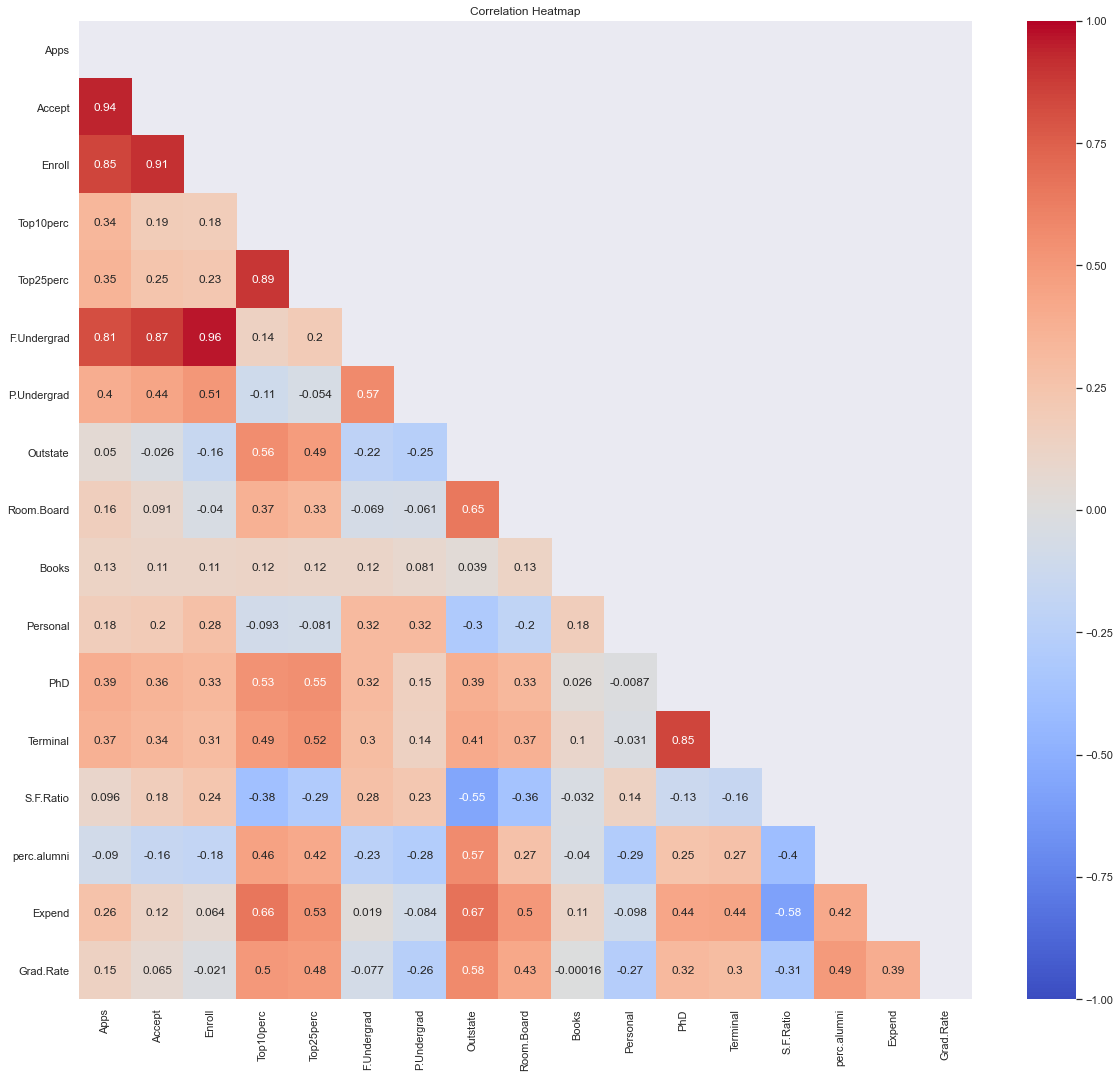

In [122]:
#Plot a heatmap of correlation between variables
plt.figure(figsize=(20,18))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) 
corr_tab = sns.heatmap(corr,annot=True,vmin=-1,vmax = 1,mask=mask,cmap='coolwarm')
plt.title('Correlation Heatmap');

### Other insights

In [123]:
print('Mean application acceptance ratio of all colleges is :{}%'.format(round(((df['Accept']/df['Apps']).mean()*100),2)))

Mean application acceptance ratio of all colleges is :74.69%


In [124]:
print('Of the number of students application accepted, average enrollment across colleges is :{}%'.
      format(round(((df['Enroll']/df['Accept']).mean()*100),2)))

Of the number of students application accepted, average enrollment across colleges is :41.2%


In [125]:
print('Number of students enrolled against application across colleges is :{}%'.
      format(round(((df['Enroll']/df['Apps']).mean()*100),2)))

Number of students enrolled against application across colleges is :30.94%


In [126]:
# lets check the percent for Top10perc students for which the PhD faculty is at 90%
df[df['Top10perc'] > 52]['PhD'].mean()

90.05714285714286

In [127]:
# lets check the percent for Top25perc students for which the PhD faculty is at 90%
df[df['Top25perc'] > 90]['PhD'].mean()

90.5

## 2.2 Is scaling necessary for PCA in this case? Give justification and perform scaling.

In [128]:
#Select all the numeric columns to perform PCA
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
Apps,777.0,3001.638353,3870.201484,81.0,776.0,1558.0,3624.0,48094.0
Accept,777.0,2018.804376,2451.113971,72.0,604.0,1110.0,2424.0,26330.0
Enroll,777.0,779.972973,929.176190,35.0,242.0,434.0,902.0,6392.0
Top10perc,777.0,27.558559,17.640364,1.0,15.0,23.0,35.0,96.0
Top25perc,777.0,55.796654,19.804778,9.0,41.0,54.0,69.0,100.0
F.Undergrad,777.0,3699.907336,4850.420531,139.0,992.0,1707.0,4005.0,31643.0
P.Undergrad,777.0,855.298584,1522.431887,1.0,95.0,353.0,967.0,21836.0
Outstate,777.0,10440.669241,4023.016484,2340.0,7320.0,9990.0,12925.0,21700.0
Room.Board,777.0,4357.526384,1096.696416,1780.0,3597.0,4200.0,5050.0,8124.0
Books,777.0,549.380952,165.105360,96.0,470.0,500.0,600.0,2340.0


In [129]:
# Apply zscore to scale and normalize the data
df_zscore = df_num.apply(zscore)
df_zscore.describe().T

,count,mean,std,min,25%,50%,75%,max
Apps,777.0,6.355797e-17,1.000644,-0.755134,-0.575441,-0.373254,0.160912,11.658671
Accept,777.0,6.774575e-17,1.000644,-0.794764,-0.577581,-0.371011,0.165417,9.924816
Enroll,777.0,-5.249269e-17,1.000644,-0.802273,-0.579351,-0.372584,0.131413,6.043678
Top10perc,777.0,-2.753232e-17,1.000644,-1.506526,-0.712380,-0.258583,0.422113,3.882319
Top25perc,777.0,-1.546739e-16,1.000644,-2.364419,-0.747607,-0.090777,0.667104,2.233391
F.Undergrad,777.0,-1.661405e-16,1.000644,-0.734617,-0.558643,-0.411138,0.062941,5.764674
P.Undergrad,777.0,-3.029180e-17,1.000644,-0.561502,-0.499719,-0.330144,0.073418,13.789921
Outstate,777.0,6.515595e-17,1.000644,-2.014878,-0.776203,-0.112095,0.617927,2.800531
Room.Board,777.0,3.570717e-16,1.000644,-2.351778,-0.693917,-0.143730,0.631824,3.436593
Books,777.0,-2.192583e-16,1.000644,-2.747779,-0.481099,-0.299280,0.306784,10.852297


## 2.3 Comment on the comparison between the covariance and the correlation matrices from this data.[on scaled data]

In [130]:
# Create the correlation matrix on the scaled data.
round(df_zscore.corr(),3)

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Apps,1.000,0.943,0.847,0.339,0.352,0.814,0.398,0.050,0.165,0.133,0.179,0.393,0.369,0.096,-0.090,0.260,0.147
Accept,0.943,1.000,0.912,0.192,0.247,0.874,0.441,-0.026,0.091,0.114,0.201,0.358,0.338,0.176,-0.160,0.125,0.065
Enroll,0.847,0.912,1.000,0.181,0.227,0.965,0.513,-0.155,-0.040,0.113,0.281,0.333,0.308,0.237,-0.181,0.064,-0.021
Top10perc,0.339,0.192,0.181,1.000,0.892,0.141,-0.105,0.562,0.371,0.119,-0.093,0.534,0.491,-0.385,0.455,0.661,0.502
Top25perc,0.352,0.247,0.227,0.892,1.000,0.199,-0.054,0.489,0.331,0.116,-0.081,0.548,0.525,-0.295,0.418,0.527,0.484
F.Undergrad,0.814,0.874,0.965,0.141,0.199,1.000,0.571,-0.216,-0.069,0.116,0.317,0.320,0.300,0.280,-0.229,0.019,-0.077
P.Undergrad,0.398,0.441,0.513,-0.105,-0.054,0.571,1.000,-0.254,-0.061,0.081,0.320,0.150,0.142,0.233,-0.281,-0.084,-0.256
Outstate,0.050,-0.026,-0.155,0.562,0.489,-0.216,-0.254,1.000,0.654,0.039,-0.299,0.387,0.408,-0.555,0.566,0.673,0.576
Room.Board,0.165,0.091,-0.040,0.371,0.331,-0.069,-0.061,0.654,1.000,0.128,-0.199,0.332,0.375,-0.363,0.272,0.502,0.426
Books,0.133,0.114,0.113,0.119,0.116,0.116,0.081,0.039,0.128,1.000,0.179,0.026,0.100,-0.032,-0.040,0.112,-0.000


In [131]:
# Create the covariance matrix on the scaled data.
round(df_zscore.cov(),3)

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Apps,1.001,0.945,0.848,0.339,0.352,0.816,0.399,0.050,0.165,0.133,0.179,0.393,0.370,0.096,-0.090,0.260,0.147
Accept,0.945,1.001,0.913,0.193,0.248,0.875,0.442,-0.026,0.091,0.114,0.201,0.358,0.338,0.176,-0.160,0.125,0.065
Enroll,0.848,0.913,1.001,0.182,0.227,0.966,0.514,-0.156,-0.040,0.113,0.281,0.334,0.309,0.238,-0.181,0.064,-0.021
Top10perc,0.339,0.193,0.182,1.001,0.893,0.141,-0.105,0.563,0.372,0.119,-0.093,0.534,0.492,-0.385,0.456,0.662,0.503
Top25perc,0.352,0.248,0.227,0.893,1.001,0.200,-0.054,0.490,0.332,0.116,-0.081,0.549,0.525,-0.295,0.418,0.528,0.485
F.Undergrad,0.816,0.875,0.966,0.141,0.200,1.001,0.571,-0.216,-0.069,0.116,0.318,0.321,0.300,0.280,-0.230,0.019,-0.077
P.Undergrad,0.399,0.442,0.514,-0.105,-0.054,0.571,1.001,-0.254,-0.061,0.081,0.320,0.151,0.142,0.233,-0.281,-0.084,-0.257
Outstate,0.050,-0.026,-0.156,0.563,0.490,-0.216,-0.254,1.001,0.655,0.039,-0.299,0.387,0.409,-0.556,0.567,0.674,0.577
Room.Board,0.165,0.091,-0.040,0.372,0.332,-0.069,-0.061,0.655,1.001,0.128,-0.200,0.333,0.375,-0.363,0.273,0.502,0.426
Books,0.133,0.114,0.113,0.119,0.116,0.116,0.081,0.039,0.128,1.001,0.180,0.026,0.100,-0.032,-0.040,0.113,-0.000


## 2.4 Check the dataset for outliers before and after scaling. What insight do you derive here?

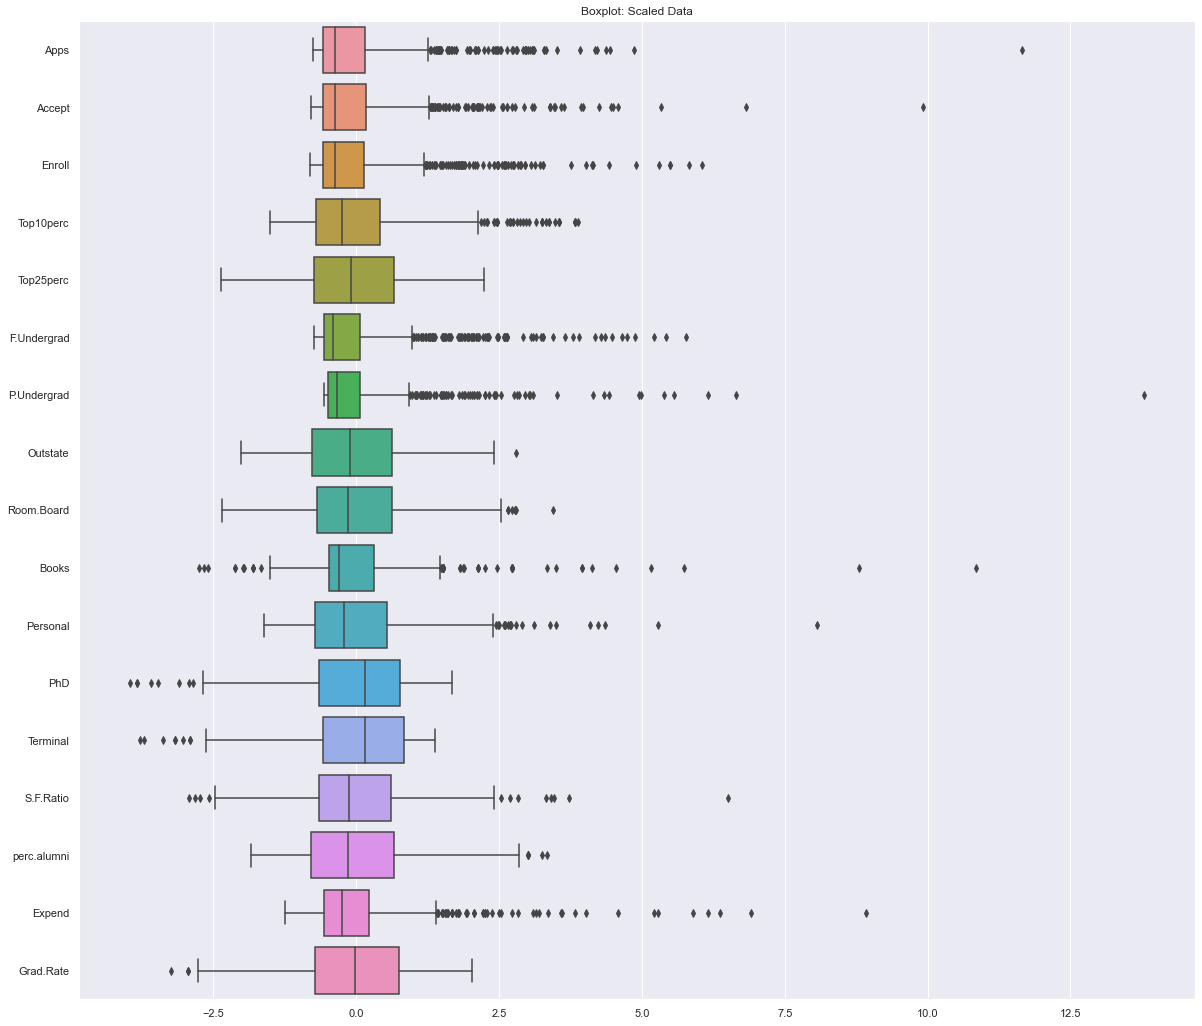

In [132]:
# Boxplot of scaled factors
plt.figure(figsize=(20,18));
sns.boxplot(data=df_zscore,orient = 'h');
plt.title('Boxplot: Scaled Data');

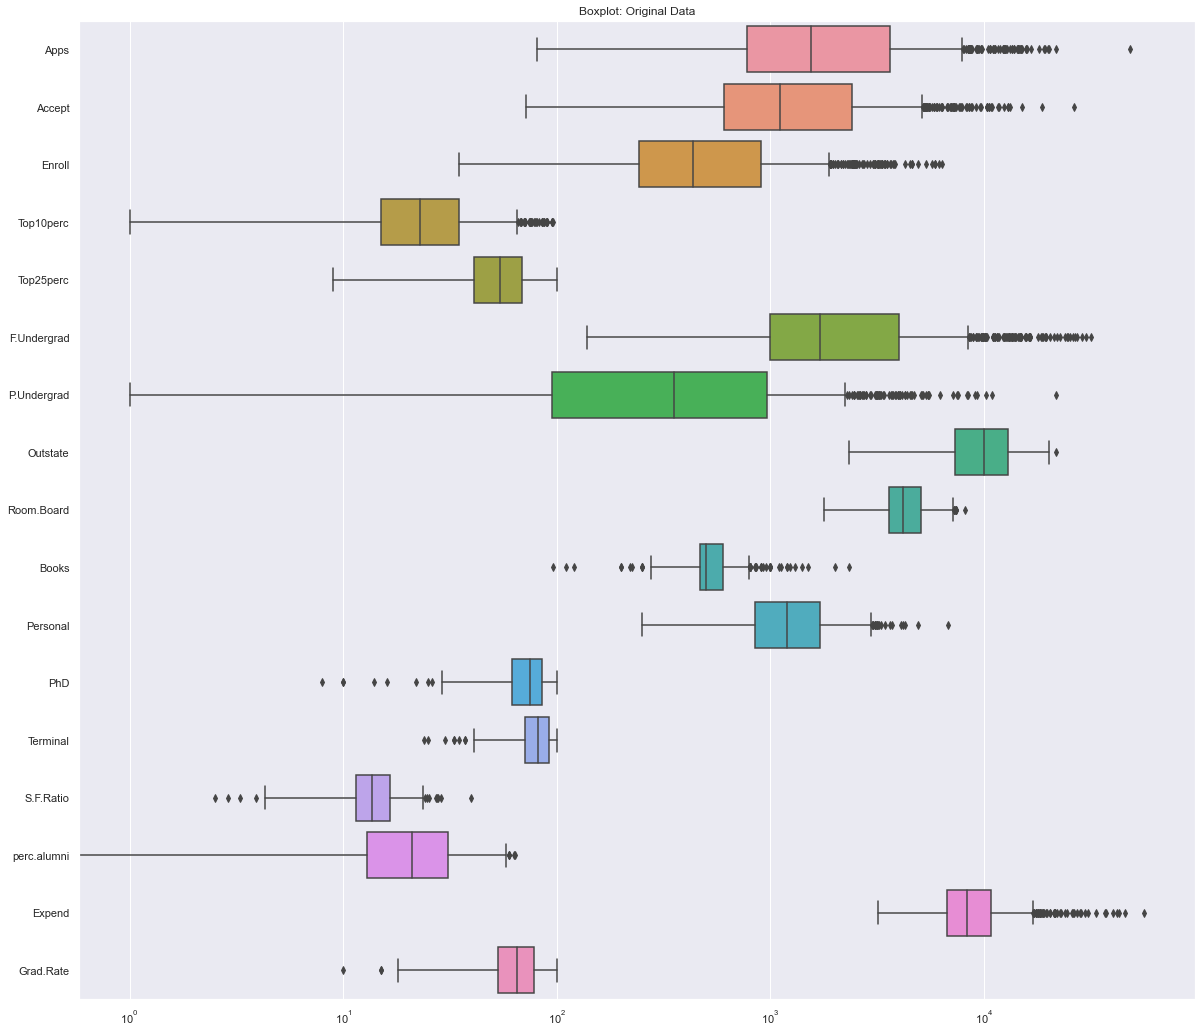

In [133]:
# Boxplot of original factors
plt.figure(figsize=(20,18))
sns.boxplot(data=df_num,orient = 'h')
plt.xscale('log');
plt.title('Boxplot: Original Data');

## 2.5 Extract the eigenvalues and eigenvectors. [Using Sklearn PCA Print Both]

In [134]:
#lets use PCA on the scaled dataset
pca = PCA(n_components=17, random_state=123)
df_pca = pca.fit_transform(df_zscore)

In [135]:
# Check the eigen values
pca.explained_variance_

array([5.46384062, 4.4841809 , 1.17453449, 0.99793705, 0.93465879,
       0.84734458, 0.60586408, 0.58783511, 0.53014189, 0.40354672,
       0.3131535 , 0.22030447, 0.16777512, 0.14299858, 0.08806661,
       0.03671503, 0.02300969])

In [136]:
# Check the eigen vector
pca.components_

array([[ 2.47532537e-01,  2.06299756e-01,  1.75138842e-01,
         3.53990557e-01,  3.43702467e-01,  1.53527590e-01,
         2.57859287e-02,  2.94965994e-01,  2.48896885e-01,
         6.42827785e-02, -4.25981738e-02,  3.19579232e-01,
         3.16776477e-01, -1.77164491e-01,  2.05418014e-01,
         3.18605544e-01,  2.55626868e-01],
       [ 3.32426877e-01,  3.72875058e-01,  4.04250640e-01,
        -8.15077765e-02, -4.39140881e-02,  4.18089297e-01,
         3.15119134e-01, -2.48748173e-01, -1.36927922e-01,
         5.66066526e-02,  2.19634151e-01,  5.88540448e-02,
         4.70008357e-02,  2.46076655e-01, -2.46023579e-01,
        -1.30727369e-01, -1.68686285e-01],
       [-5.96777039e-02, -9.77593828e-02, -8.13575684e-02,
         3.42794420e-02, -2.55085723e-02, -6.05628562e-02,
         1.37966832e-01,  4.81491197e-02,  1.52143504e-01,
         6.79693620e-01,  4.95300078e-01, -1.31903121e-01,
        -7.09715596e-02, -2.91240091e-01, -1.47090056e-01,
         2.27918829e-01, -2.0

## 2.6	Perform PCA and export the data of the Principal Component (eigenvectors) into a data frame with the original features.

In [137]:
# Create a dataframe which shows the principal components and the loading of each of the original factors.
df_PCA_eigenvectors = pd.DataFrame(pca.components_,columns = df_zscore.columns, index = ['PC1','PC2','PC3','PC4','PC5','PC6',
                                                                                         'PC7','PC8','PC9','PC10','PC11','PC12',
                                                                                         'PC13','PC14','PC15','PC16','PC17']).T
print('Eigenvectors against original features')
df_PCA_eigenvectors

Eigenvectors against original features


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
Apps,0.247533,0.332427,-0.059678,0.285097,0.000170,-0.012281,-0.030660,-0.103577,-0.089330,0.050736,0.043174,0.023386,0.597045,0.066050,0.132823,0.459050,0.359723
Accept,0.206300,0.372875,-0.097759,0.271788,0.050617,0.011277,-0.002812,-0.055528,-0.176711,0.040550,-0.058653,-0.146703,0.292920,0.026252,-0.144995,-0.517548,-0.544054
Enroll,0.175139,0.404251,-0.081358,0.163457,-0.058798,-0.040120,-0.023540,0.058316,-0.128035,0.031462,-0.068365,0.012105,-0.446935,-0.073935,0.029958,-0.405328,0.609048
Top10perc,0.353991,-0.081508,0.034279,-0.055180,-0.394019,-0.054194,-0.164626,-0.129536,0.338332,0.064027,-0.008774,0.037884,-0.001603,-0.107537,0.698037,-0.147935,-0.144813
Top25perc,0.343702,-0.043914,-0.025509,-0.115855,-0.423913,0.030869,-0.125836,-0.108117,0.401042,0.014305,-0.274017,-0.091124,0.024861,0.149297,-0.617397,0.051906,0.080497
F.Undergrad,0.153528,0.418089,-0.060563,0.101292,-0.045408,-0.041727,-0.024012,0.078238,-0.059259,0.017491,-0.079953,0.057649,-0.525320,-0.042888,0.010032,0.560675,-0.414018
P.Undergrad,0.025786,0.315119,0.137967,-0.158951,0.306058,-0.193339,0.025111,0.570135,0.561029,-0.223975,0.102021,-0.062850,0.126510,0.019433,0.020998,-0.053128,0.008725
Outstate,0.294966,-0.248748,0.048149,0.136572,0.220140,-0.026773,0.112136,0.014622,-0.001203,0.181787,0.146199,-0.822908,-0.145891,-0.025842,0.039539,0.102095,0.051413
Room.Board,0.248897,-0.136928,0.152144,0.191576,0.556677,0.167220,0.218058,-0.212996,0.280844,0.293449,-0.360912,0.352609,-0.071835,-0.057215,0.003699,-0.025662,0.001239
Books,0.064283,0.056607,0.679694,0.071380,-0.131995,0.640262,-0.150371,0.207821,-0.135860,-0.085032,0.033481,-0.027690,0.009824,-0.068210,-0.009576,0.002851,0.000740


## 2.7 Write down the explicit form of the first PC (in terms of the eigenvectors. Use values with two places of decimals only). [hint: write the linear equation of PC in terms of eigenvectors and corresponding features]

In [138]:
# Check the loading of original factors for principal component
df_PCA_eigenvectors.iloc[:,0]

Apps           0.247533
Accept         0.206300
Enroll         0.175139
Top10perc      0.353991
Top25perc      0.343702
F.Undergrad    0.153528
P.Undergrad    0.025786
Outstate       0.294966
Room.Board     0.248897
Books          0.064283
Personal      -0.042598
PhD            0.319579
Terminal       0.316776
S.F.Ratio     -0.177164
perc.alumni    0.205418
Expend         0.318606
Grad.Rate      0.255627
Name: PC1, dtype: float64

## 2.8 Consider the cumulative values of the eigenvalues. How does it help you to decide on the optimum number of principal components? What do the eigenvectors indicate?

In [139]:
# Check the eigen values
pca.explained_variance_

array([5.46384062, 4.4841809 , 1.17453449, 0.99793705, 0.93465879,
       0.84734458, 0.60586408, 0.58783511, 0.53014189, 0.40354672,
       0.3131535 , 0.22030447, 0.16777512, 0.14299858, 0.08806661,
       0.03671503, 0.02300969])

In [140]:
# Check the cumulative sum of eigen values
np.cumsum(pca.explained_variance_)

array([ 5.46384062,  9.94802151, 11.12255601, 12.12049306, 13.05515185,
       13.90249643, 14.50836051, 15.09619562, 15.6263375 , 16.02988422,
       16.34303772, 16.56334219, 16.73111731, 16.87411589, 16.9621825 ,
       16.99889753, 17.02190722])

In [141]:
# Check the explained variance ratio
pca.explained_variance_ratio_

array([0.32098874, 0.26343587, 0.06900134, 0.05862663, 0.05490917,
       0.04977965, 0.0355932 , 0.03453403, 0.03114468, 0.02370749,
       0.01839709, 0.01294241, 0.00985642, 0.00840086, 0.00517372,
       0.00215693, 0.00135177])

In [142]:
# Check the cumulative sum of explained variance ratio
np.cumsum(pca.explained_variance_ratio_)

array([0.32098874, 0.58442461, 0.65342596, 0.71205259, 0.76696176,
       0.81674141, 0.8523346 , 0.88686863, 0.91801332, 0.94172081,
       0.96011789, 0.9730603 , 0.98291673, 0.99131758, 0.9964913 ,
       0.99864823, 1.        ])

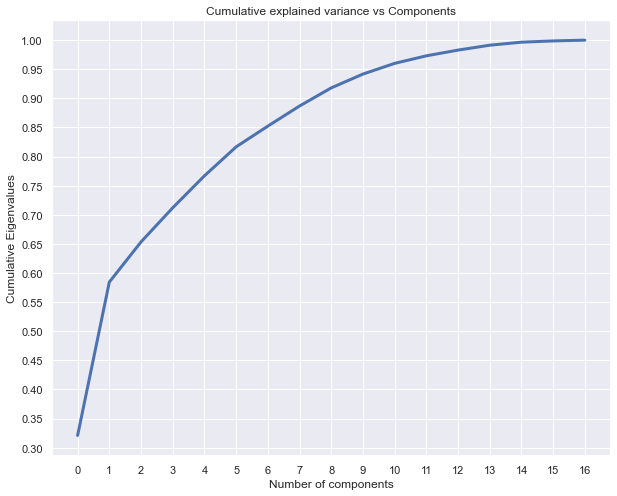

In [143]:
# Plot the cumulative sum of explained variance ratio to see contribution of each component towards the variance.
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth=3)
plt.xticks(np.arange(0,17,1));
plt.yticks(np.arange(0.3,1.05,0.05));
plt.xlabel('Number of components');
plt.ylabel('Cumulative Eigenvalues');
plt.title('Cumulative explained variance vs Components');

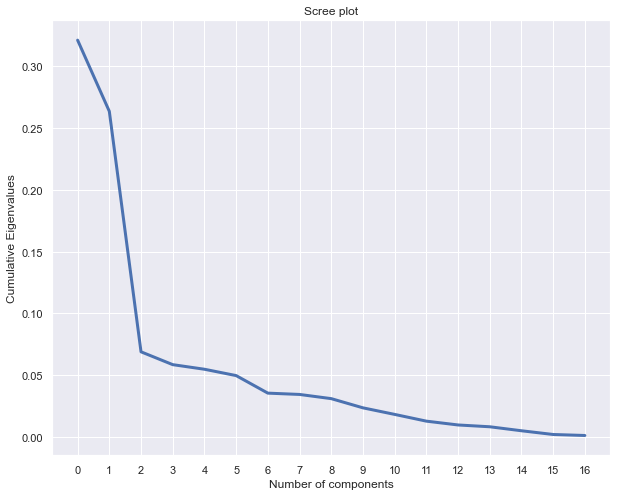

In [144]:
# Plot the screeplot to check variance associated with each component
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_,linewidth=3)
plt.xticks(np.arange(0,17,1));
#plt.yticks(np.arange(0.3,1.05,0.05));
plt.xlabel('Number of components');
plt.ylabel('Cumulative Eigenvalues');
plt.title('Scree plot');

## 2.9	Explain the business implication of using the Principal Component Analysis for this case study. How may PCs help in the further analysis? [Hint: Write Interpretations of the Principal Components Obtained]

In [145]:
# Transform the eigenvector dataframe
df_pca_loading = df_PCA_eigenvectors.T.iloc[:8,:]
df_pca_loading

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
PC1,0.247533,0.206300,0.175139,0.353991,0.343702,0.153528,0.025786,0.294966,0.248897,0.064283,-0.042598,0.319579,0.316776,-0.177164,0.205418,0.318606,0.255627
PC2,0.332427,0.372875,0.404251,-0.081508,-0.043914,0.418089,0.315119,-0.248748,-0.136928,0.056607,0.219634,0.058854,0.047001,0.246077,-0.246024,-0.130727,-0.168686
PC3,-0.059678,-0.097759,-0.081358,0.034279,-0.025509,-0.060563,0.137967,0.048149,0.152144,0.679694,0.495300,-0.131903,-0.070972,-0.291240,-0.147090,0.227919,-0.205241
PC4,0.285097,0.271788,0.163457,-0.055180,-0.115855,0.101292,-0.158951,0.136572,0.191576,0.071380,-0.249033,-0.529195,-0.518145,-0.168468,0.016115,0.086067,0.243113
PC5,0.000170,0.050617,-0.058798,-0.394019,-0.423913,-0.045408,0.306058,0.220140,0.556677,-0.131995,-0.217224,0.150814,0.214616,-0.077059,-0.215815,0.074993,-0.115718
PC6,-0.012281,0.011277,-0.040120,-0.054194,0.030869,-0.041727,-0.193339,-0.026773,0.167220,0.640262,-0.337698,0.083092,0.149282,0.485844,-0.047150,-0.297458,0.215657
PC7,-0.030660,-0.002812,-0.023540,-0.164626,-0.125836,-0.024012,0.025111,0.112136,0.218058,-0.150371,0.637300,-0.002578,-0.041755,0.213980,0.221097,-0.224279,0.564576
PC8,-0.103577,-0.055528,0.058316,-0.129536,-0.108117,0.078238,0.570135,0.014622,-0.212996,0.207821,-0.208242,-0.077274,-0.014063,-0.075494,0.689203,-0.062600,0.014859


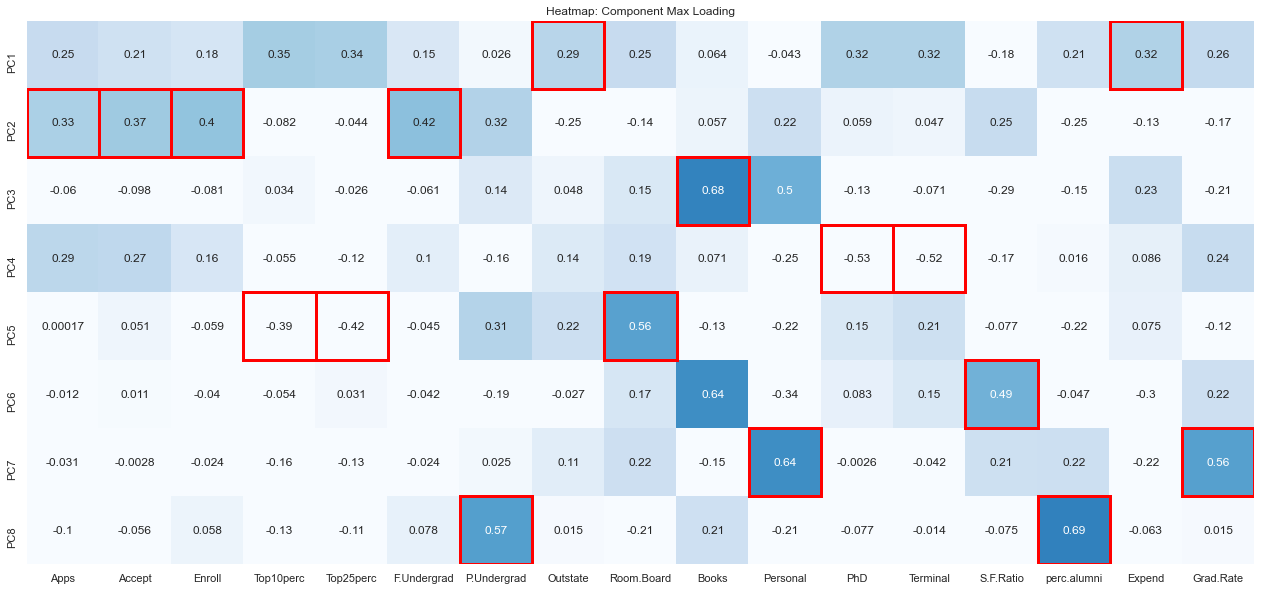

In [146]:
# Plot heatmap to see the loading of original factors on PCA
from matplotlib.patches import Rectangle
fig,ax = plt.subplots(figsize=(22, 10), facecolor='w', edgecolor='k')
ax = sns.heatmap(df_pca_loading, annot=True, vmax=1.0, vmin=0, cmap='Blues', cbar=False, fmt='.2g', ax=ax,
                 yticklabels=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
plt.title('Heatmap: Component Max Loading')

column_max = df_pca_loading.abs().idxmax(axis=0)

for col, variable in enumerate(df_pca_loading.columns):
    position = df_pca_loading.index.get_loc(column_max[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))